# Elevated-Plus Maze Analysis

In [1]:
from analysis import analysis_utils as au
from IPython.core.interactiveshell import InteractiveShell
from multiprocessing import Process
from multiprocessing import Queue
import numpy as np
import os
import pandas as pd
import random
from scipy import stats
import seaborn as sns
import SigProc
import sys

In [2]:
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"
sns.set_style("darkgrid")

## Organize all the files for each mouse. Go through the EPM directory, and for each mouse, add the corresponding behavior data file path name and the corresponding Raw data file path name to a dictionary.

In [3]:
mouse_directory = os.path.expanduser("~") + "/Hen_Lab/Mice/EPM"

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)

animal_data_files = dict()

for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    if subdir_list:
        mice_directories = subdir_list

    for file_name in file_list:
        for mouse_name in mice_directories:
            if file_name.endswith(".csv") and (mouse_name in file_name and "behavior" in file_name):
                if mouse_name in animal_data_files:
                    animal_data_files[mouse_name].update({"behavior":dir_name+"/"+file_name})
                else:
                    animal_data_files[mouse_name] = {"behavior":dir_name+"/"+file_name}
            elif file_name.endswith(".csv") and (mouse_name in file_name and "Raw" in file_name):
                if mouse_name in animal_data_files:
                    animal_data_files[mouse_name].update({"Raw":dir_name+"/"+file_name})
                else:
                    animal_data_files[mouse_name] = {"Raw":dir_name+"/"+file_name}

In [4]:
animal_data_files

{'drd87': {'behavior': '/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/behavior_drd87.csv',
  'Raw': '/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Raw_EPM_drd87.csv'},
 'drd73': {'Raw': '/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/Raw_EPM_drd73.csv',
  'behavior': '/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/behavior_drd73.csv'},
 'drd77': {'Raw': '/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77/Raw_EPM_drd77.csv',
  'behavior': '/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77/behavior_drd77.csv'},
 'drd46': {'behavior': '/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/behavior_drd46.csv',
  'Raw': '/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/Raw_EPM_drd46.csv'}}

## If a behavior data file or a Raw data file is missing for a particular mouse, then display which file is missing. Then proceed to remove all mice from the dictionary that do not have the required data files, i.e., behavior and raw.

In [5]:
# Check that for each animal a corresponding behavior data file AND Raw neuron data file was found
missing_data = list()
for mouse_name in animal_data_files:
    if not "behavior" in animal_data_files[mouse_name]:
        print("The behavior for {} file is missing".format(mouse_name))
        missing_data.append(mouse_name)
    if not "Raw" in animal_data_files[mouse_name]:
        print("The raw file for {} is missing".format(mouse_name))
        missing_data.append(mouse_name)
    
# Remove all mice from the dictionary if the required data files for them were not found
for animal_name in missing_data:
    if animal_name in animal_data_files:
        del animal_data_files[animal_name]

In [6]:
animal_data_files

{'drd87': {'behavior': '/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/behavior_drd87.csv',
  'Raw': '/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Raw_EPM_drd87.csv'},
 'drd73': {'Raw': '/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/Raw_EPM_drd73.csv',
  'behavior': '/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/behavior_drd73.csv'},
 'drd77': {'Raw': '/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77/Raw_EPM_drd77.csv',
  'behavior': '/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77/behavior_drd77.csv'},
 'drd46': {'behavior': '/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/behavior_drd46.csv',
  'Raw': '/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/Raw_EPM_drd46.csv'}}

### 1. Generate and store all dataframes for each animal in a dictionary. 
### 2. Plot the correlation heatmap of the neuron concatenated with behavior dataframe for each corresponding mouse
### 3. Plot the cluster map of the cell transients dataframe for each corresponding mouse

drd87
drd73
drd77
drd46


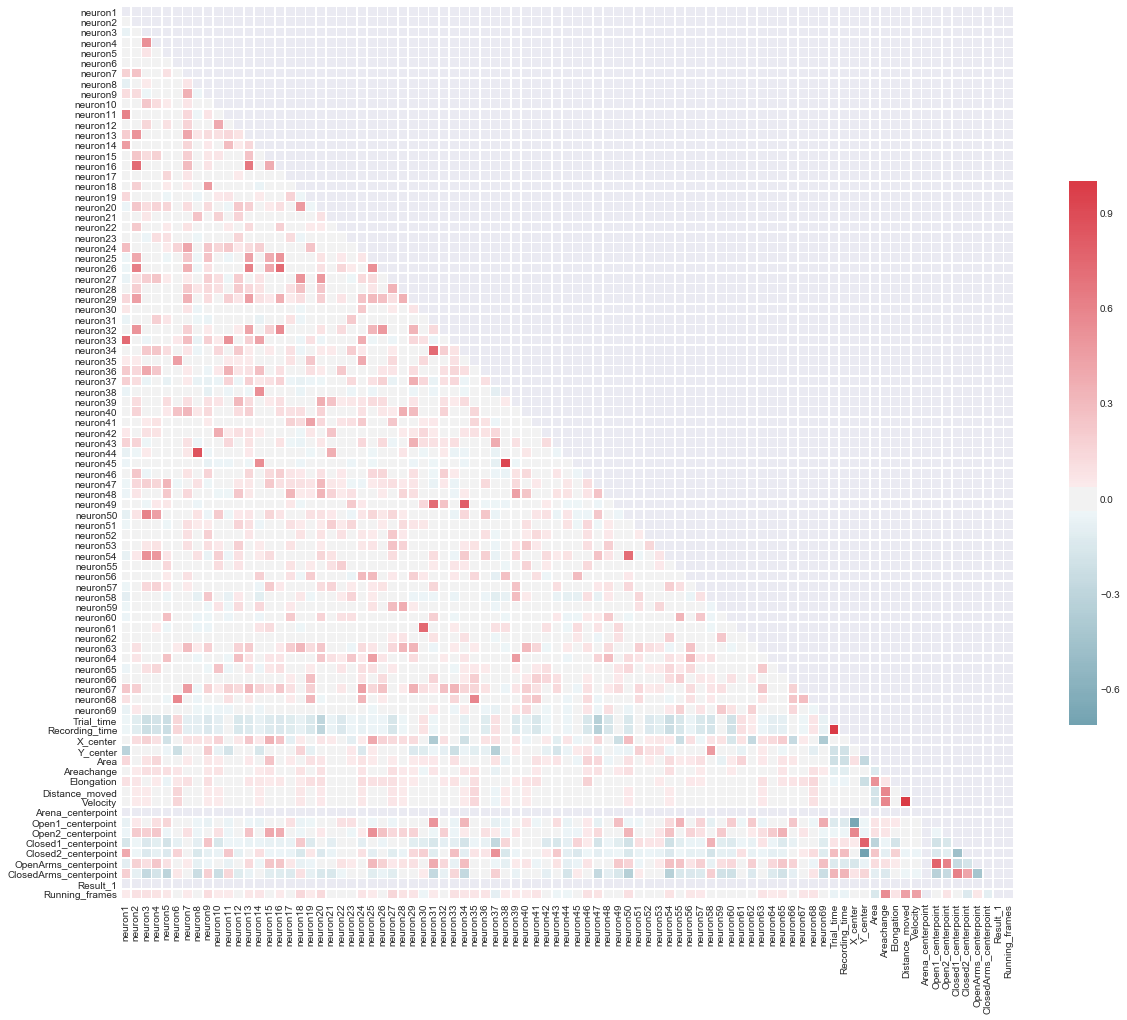

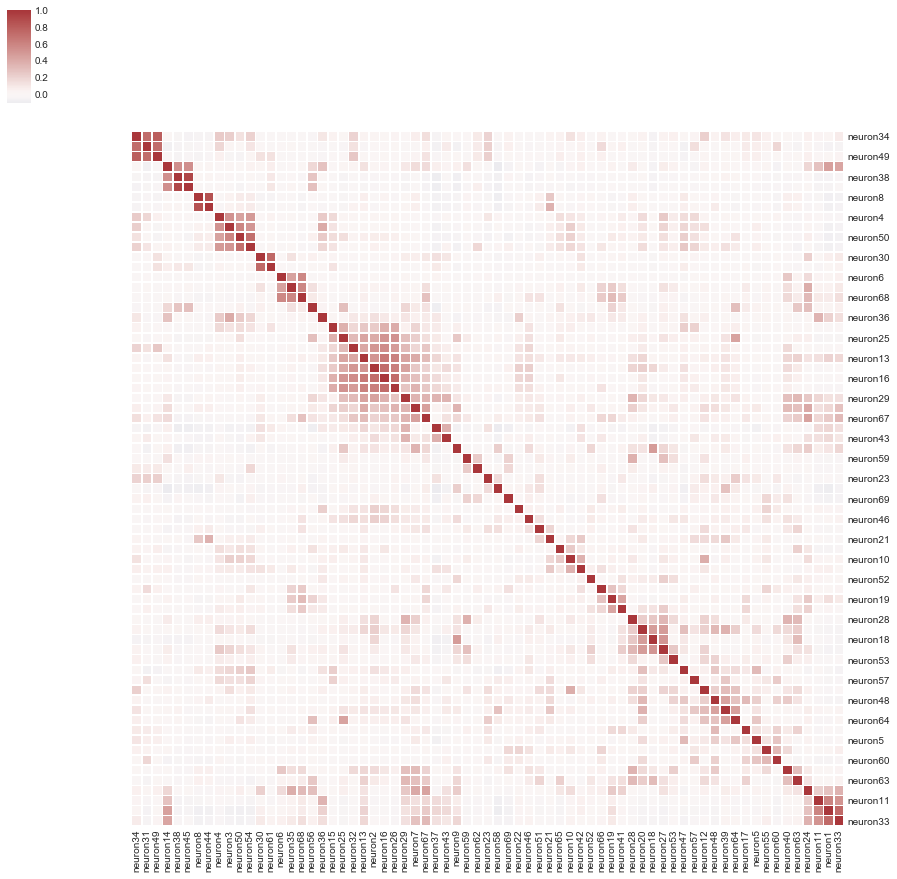

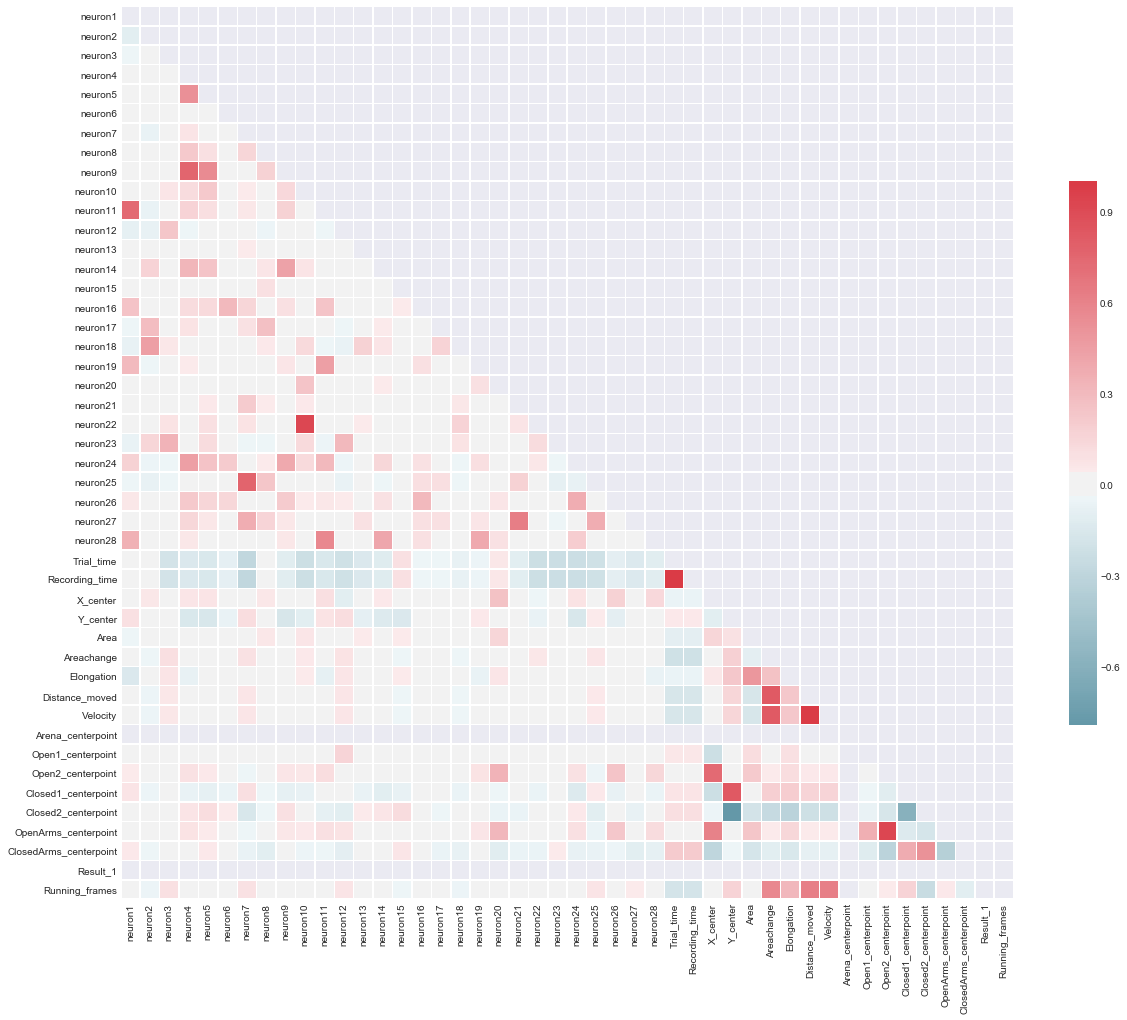

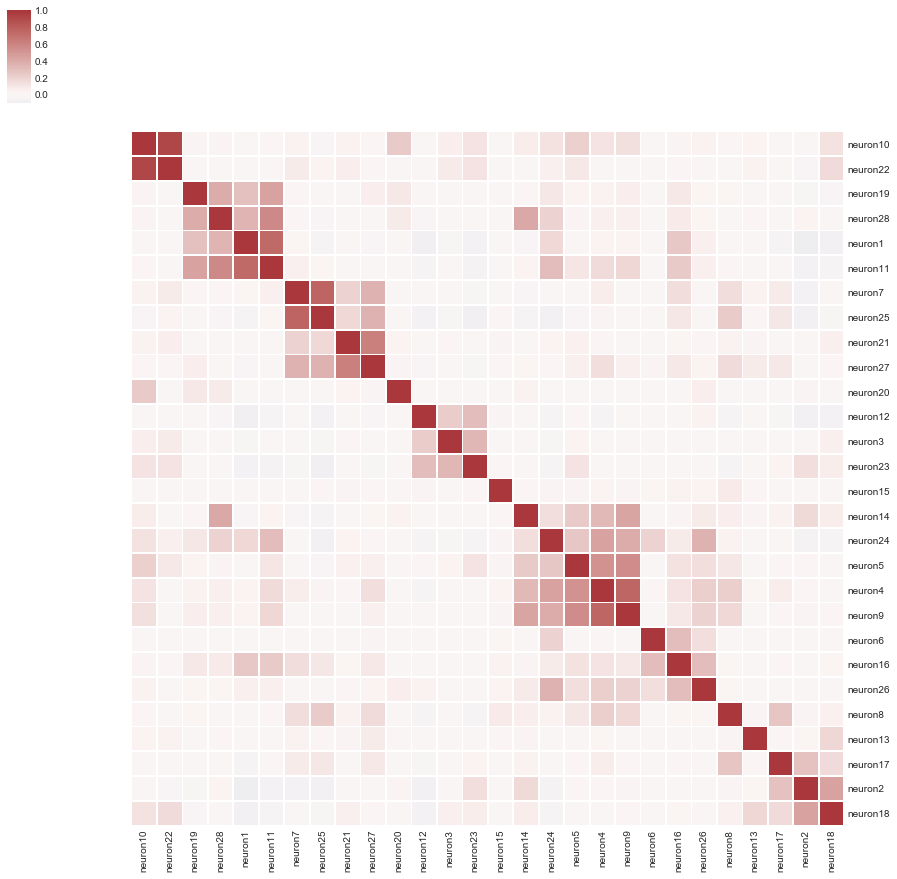

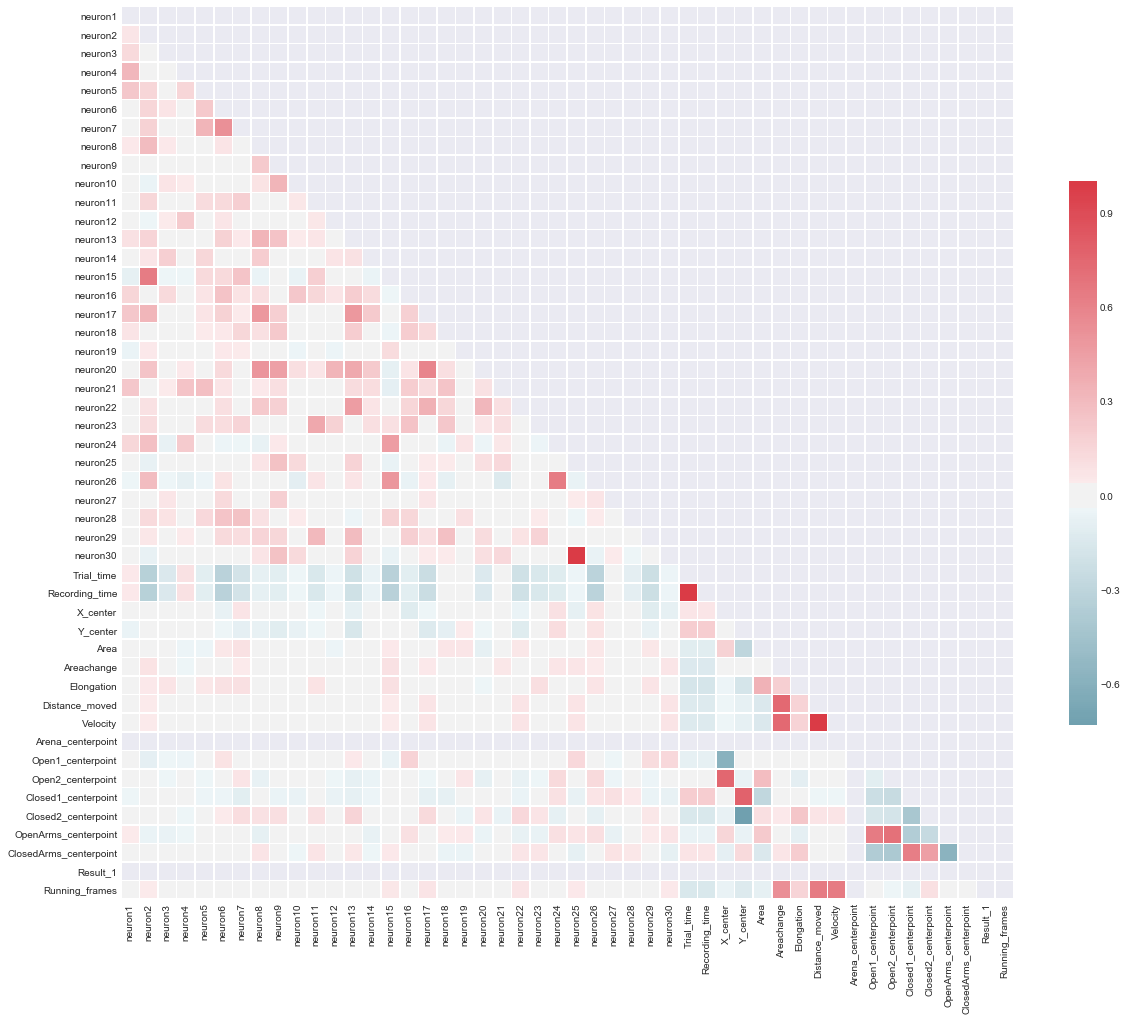

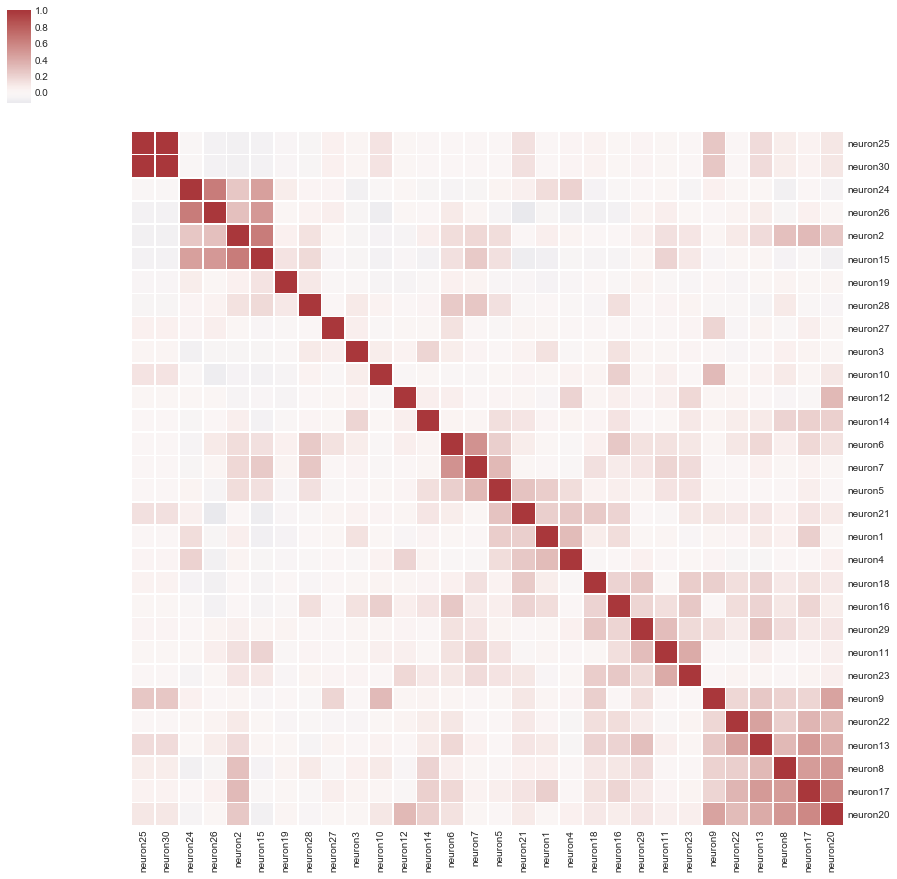

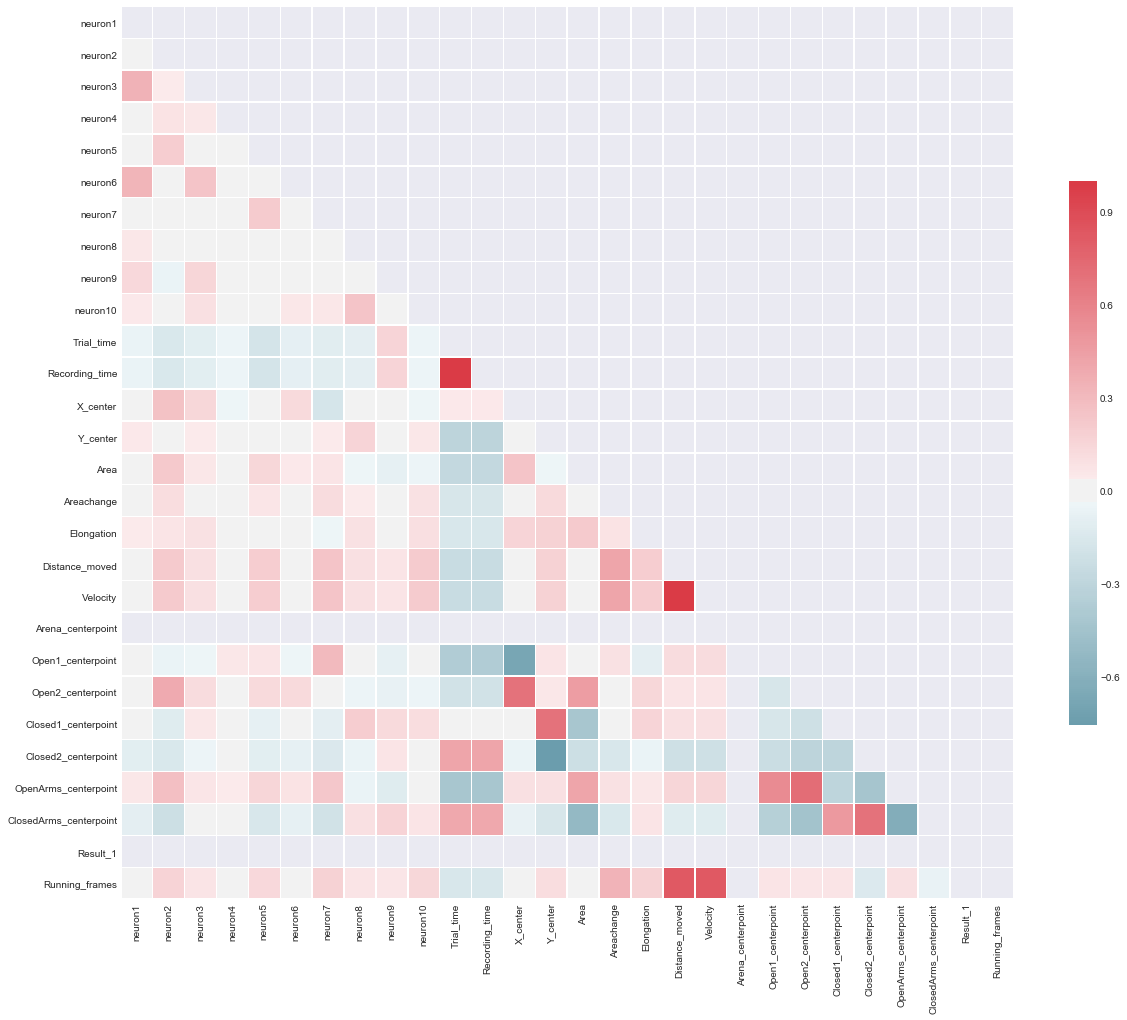

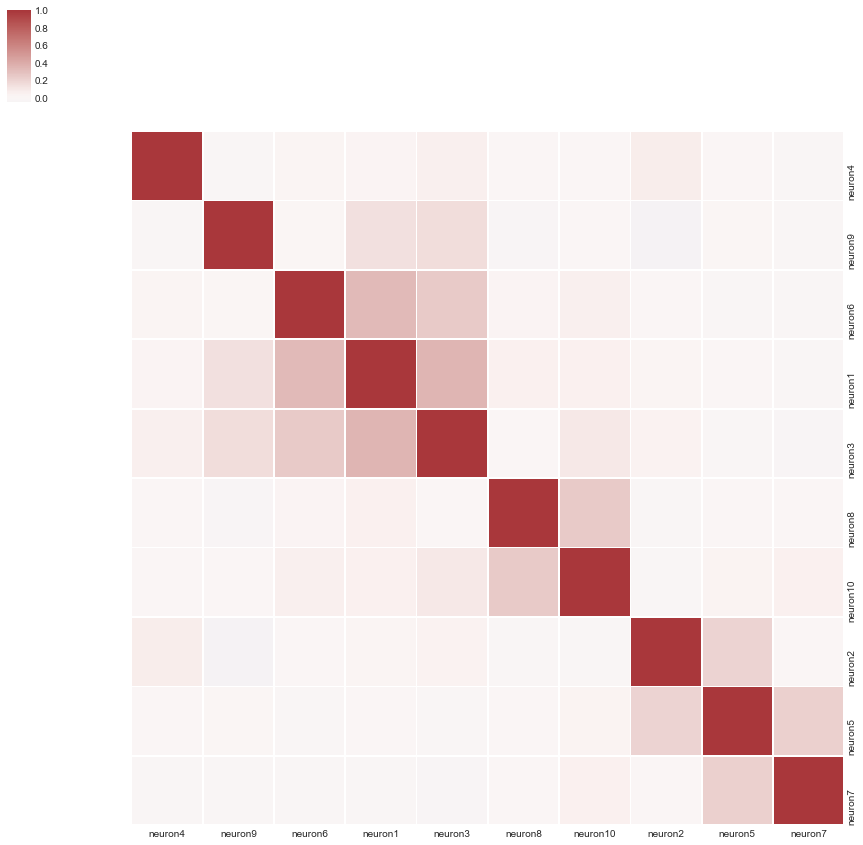

In [7]:
# Store all the dataframes for each animal in a dictionary for quick access, when needed
animal_dataframes = dict()

for animal_name in animal_data_files:
    print(animal_name)
    
    data = pd.read_csv(animal_data_files[animal_name]["Raw"], header=None)
    _, AUC_dataframe, cell_transients_dataframe = SigProc.detect_ca_transients_mossy(data, 2, 0.5, 0.2, 10)
    
    behavior_column_names = ['Trial_time', 'Recording_time', 'X_center', 'Y_center', 'Area', 'Areachange', 
                         'Elongation', 'Distance_moved', 'Velocity', 'Arena_centerpoint',
                         'Open1_centerpoint', 'Open2_centerpoint',
                         'Closed1_centerpoint', 'Closed2_centerpoint',
                         'OpenArms_centerpoint', 'ClosedArms_centerpoint', 'Result_1']

    behavior_df = pd.read_csv(animal_data_files[animal_name]["behavior"], header=None)
    behavior_df.columns = behavior_column_names
    
    # Only keep every 3rd row of the original behavior dataframe in order to downsample 30 fps --> 10 fps
    behavior_df = au.downsample_dataframe(behavior_df, 3)

    # Define cutoff for what constitutes as a running frame
    VELOCITY_CUTOFF = 4;

    # Adds "Running_frames" column to the end of the behavior dataframe 
    behavior_df["Running_frames"] = np.where(behavior_df["Velocity"] > VELOCITY_CUTOFF, 1, 0)
    
    neuron_concated_behavior = cell_transients_dataframe.join(behavior_df, how="left")
    
    # Add the corresponding AUC, cell transients, and neuron activity concated with behavior dataframes for each animal to the dictionary
    if not animal_name in animal_dataframes:
        animal_dataframes[animal_name] = {"AUC_dataframe": AUC_dataframe, "cell_transients_dataframe": cell_transients_dataframe, "neuron_concated_behavior": neuron_concated_behavior} 
    
    au.plot_correlation_heatmap(neuron_concated_behavior, size=20)
    au.plot_clustermap(cell_transients_dataframe)

## Display the correlation heat map for each animal's corresponding behaviors, e.g., open arms vs. closed arms

drd87
      ----> Arena_centerpoint
      ----> Open1_centerpoint
      ----> Open2_centerpoint
      ----> Closed1_centerpoint
      ----> Closed2_centerpoint
      ----> OpenArms_centerpoint
      ----> ClosedArms_centerpoint
drd73
      ----> Arena_centerpoint
      ----> Open1_centerpoint
      ----> Open2_centerpoint
      ----> Closed1_centerpoint
      ----> Closed2_centerpoint
      ----> OpenArms_centerpoint
      ----> ClosedArms_centerpoint
drd77
      ----> Arena_centerpoint
      ----> Open1_centerpoint
      ----> Open2_centerpoint
      ----> Closed1_centerpoint
      ----> Closed2_centerpoint
      ----> OpenArms_centerpoint
      ----> ClosedArms_centerpoint


/anaconda3/envs/algotrading/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



drd46
      ----> Arena_centerpoint
      ----> Open1_centerpoint
      ----> Open2_centerpoint
      ----> Closed1_centerpoint
      ----> Closed2_centerpoint
      ----> OpenArms_centerpoint
      ----> ClosedArms_centerpoint


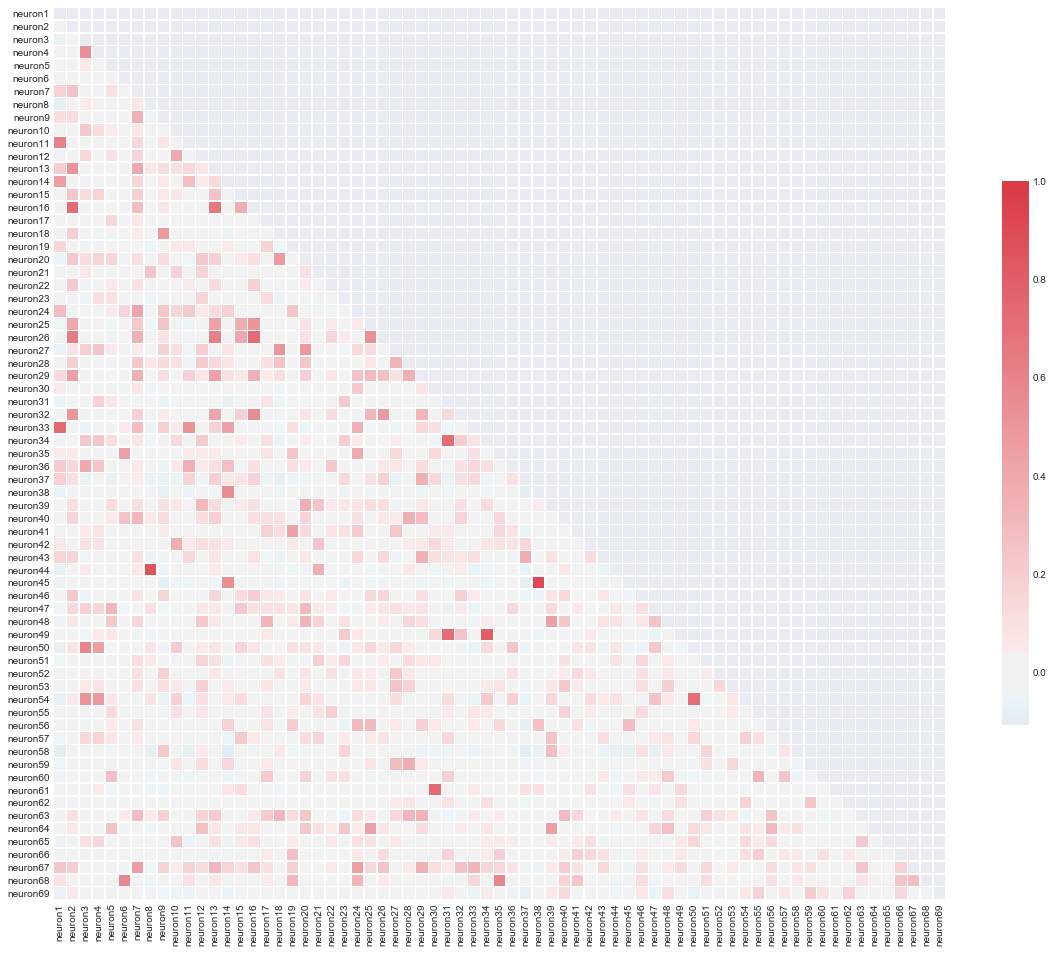

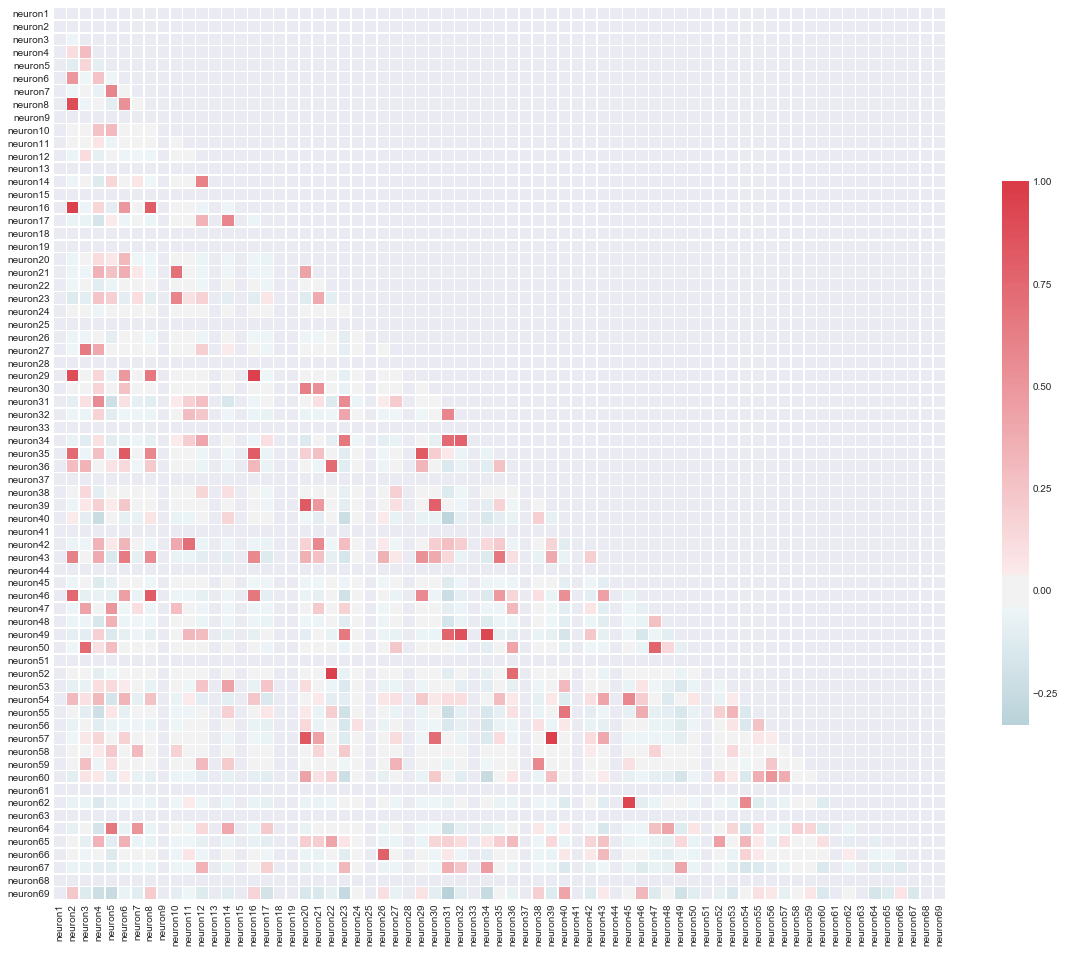

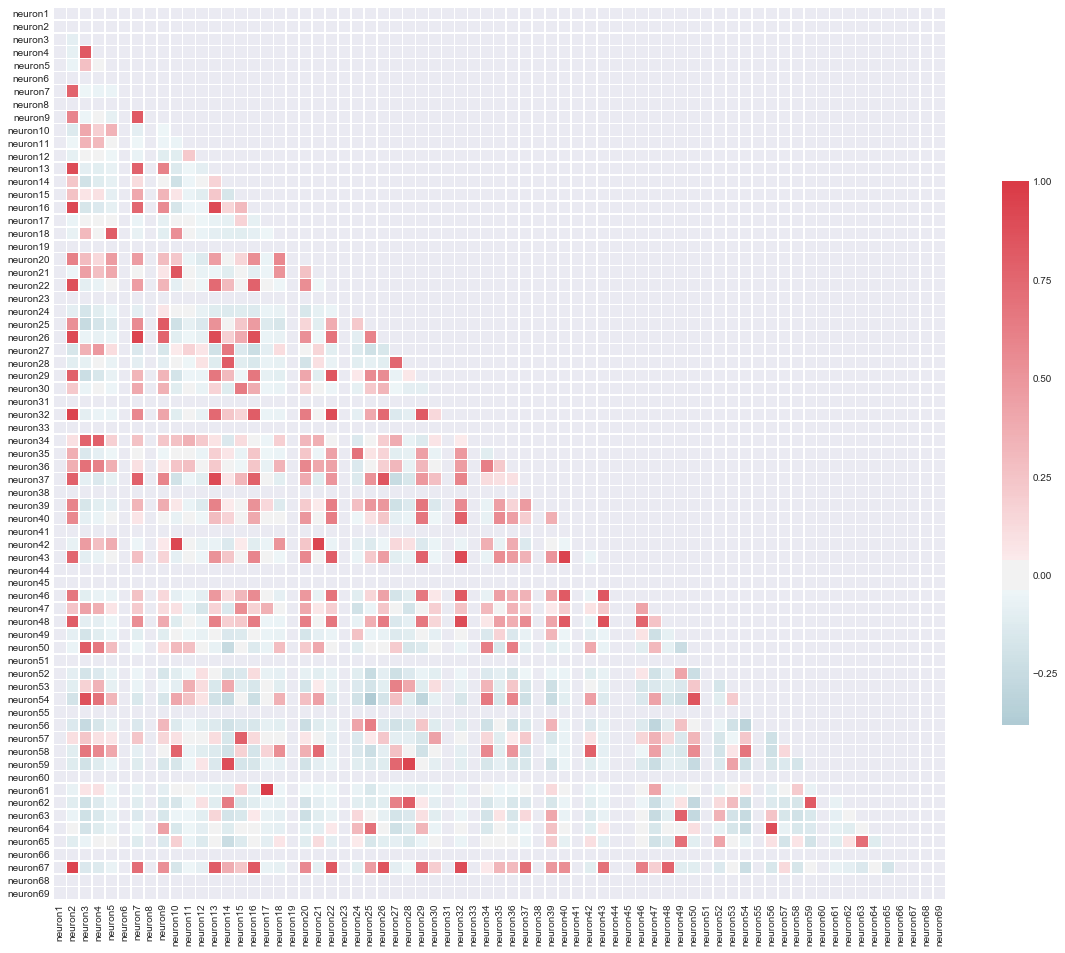

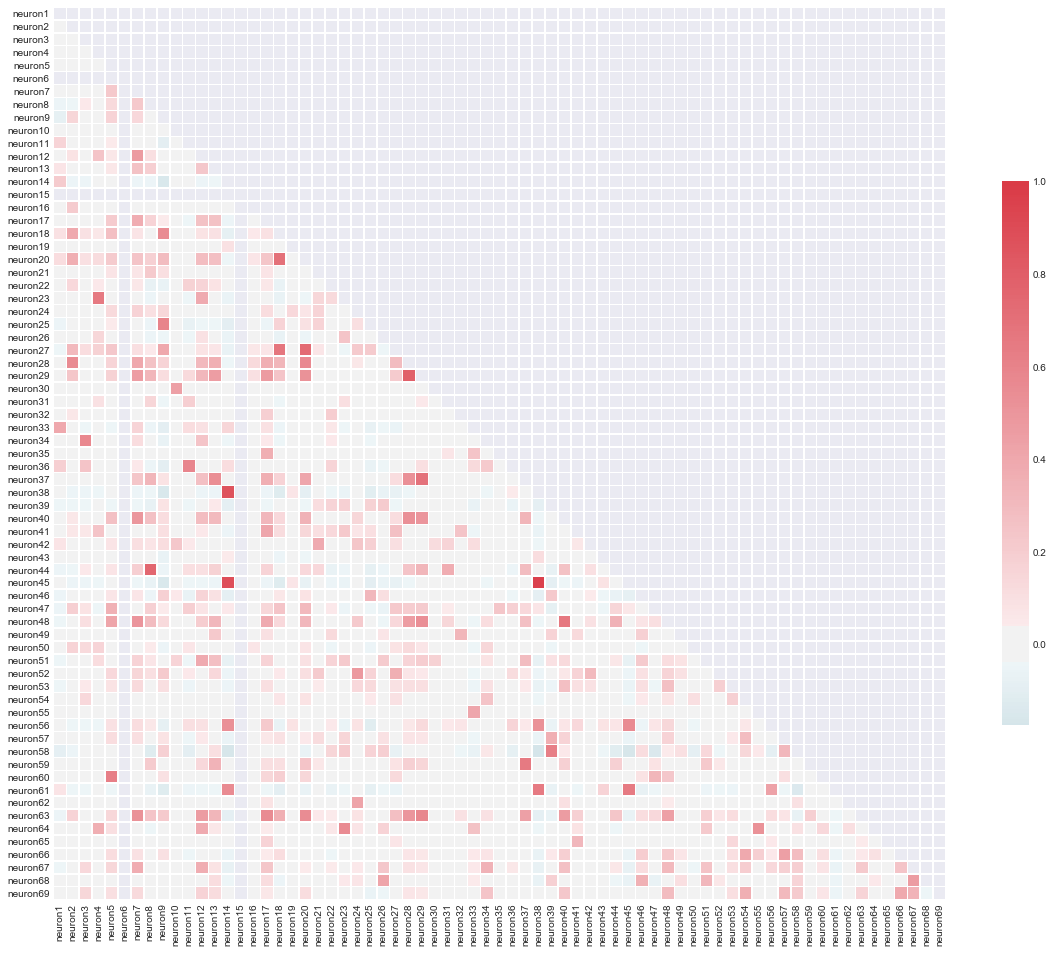

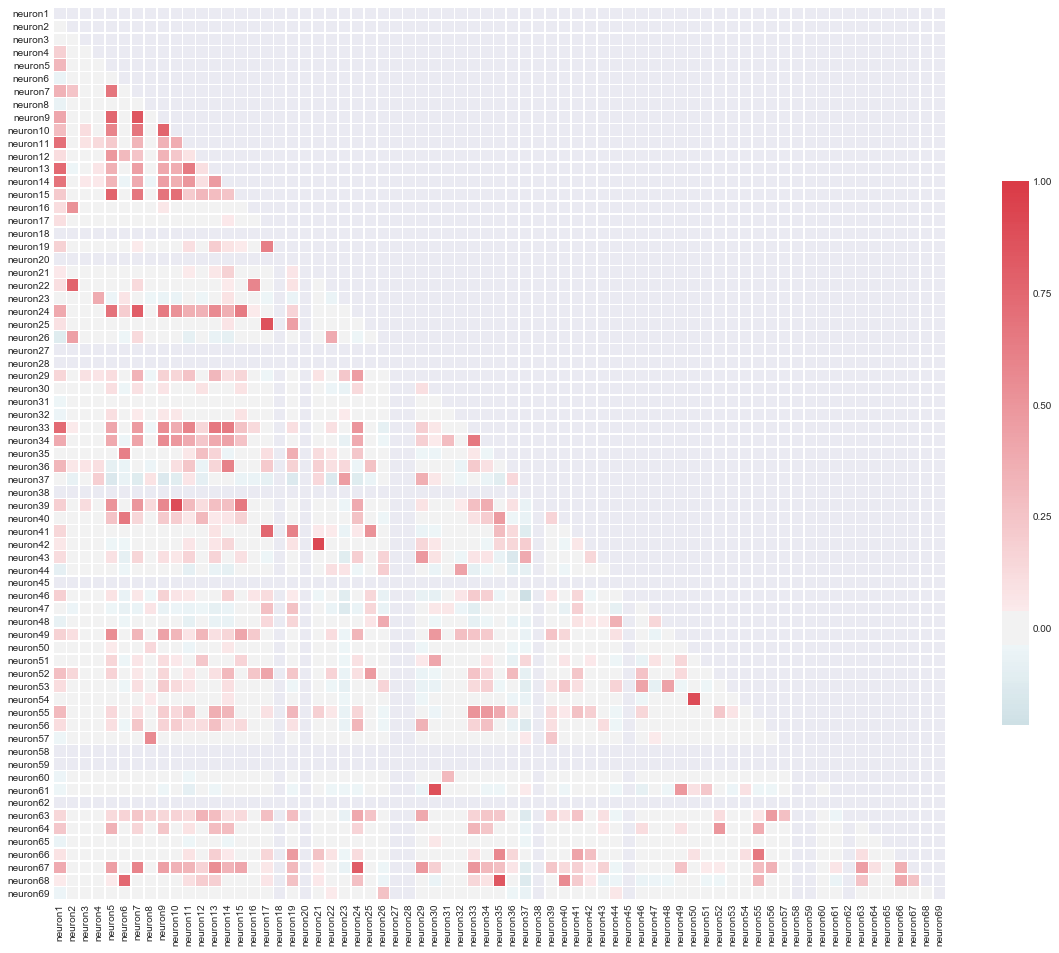

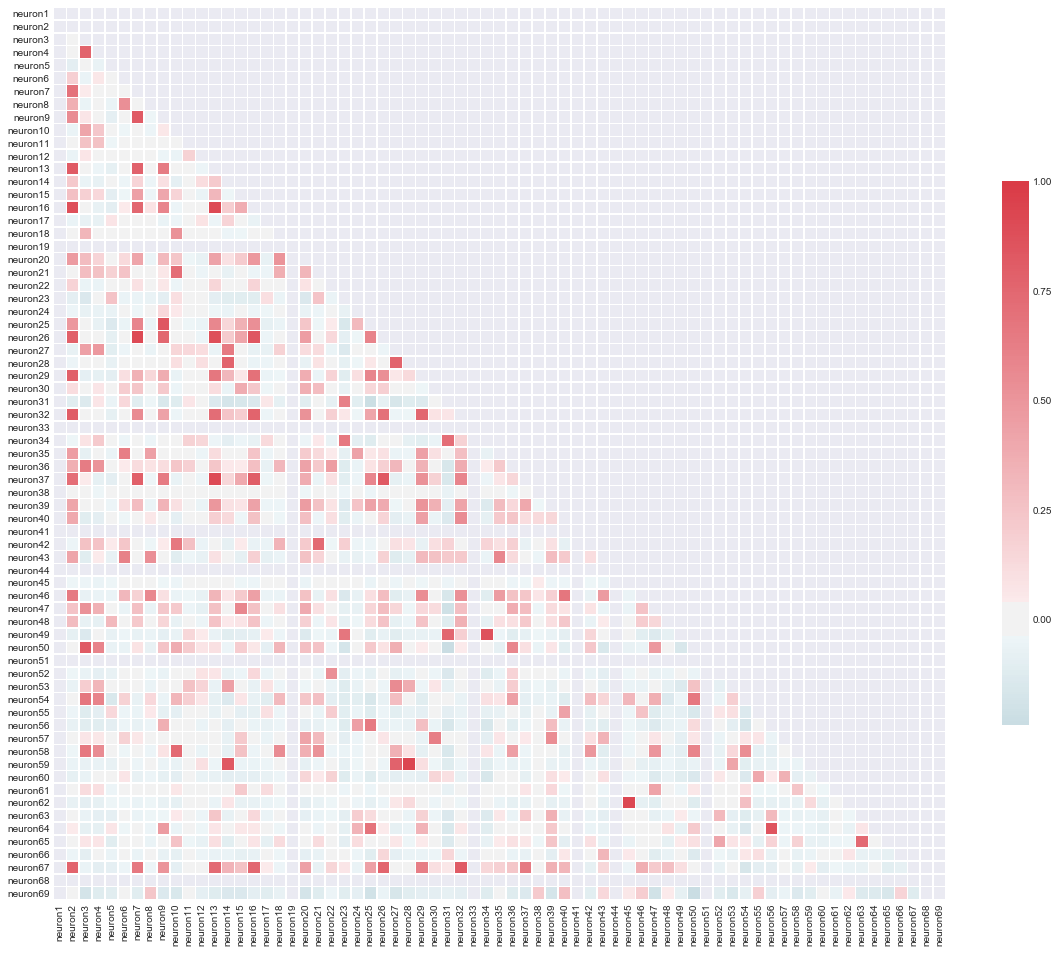

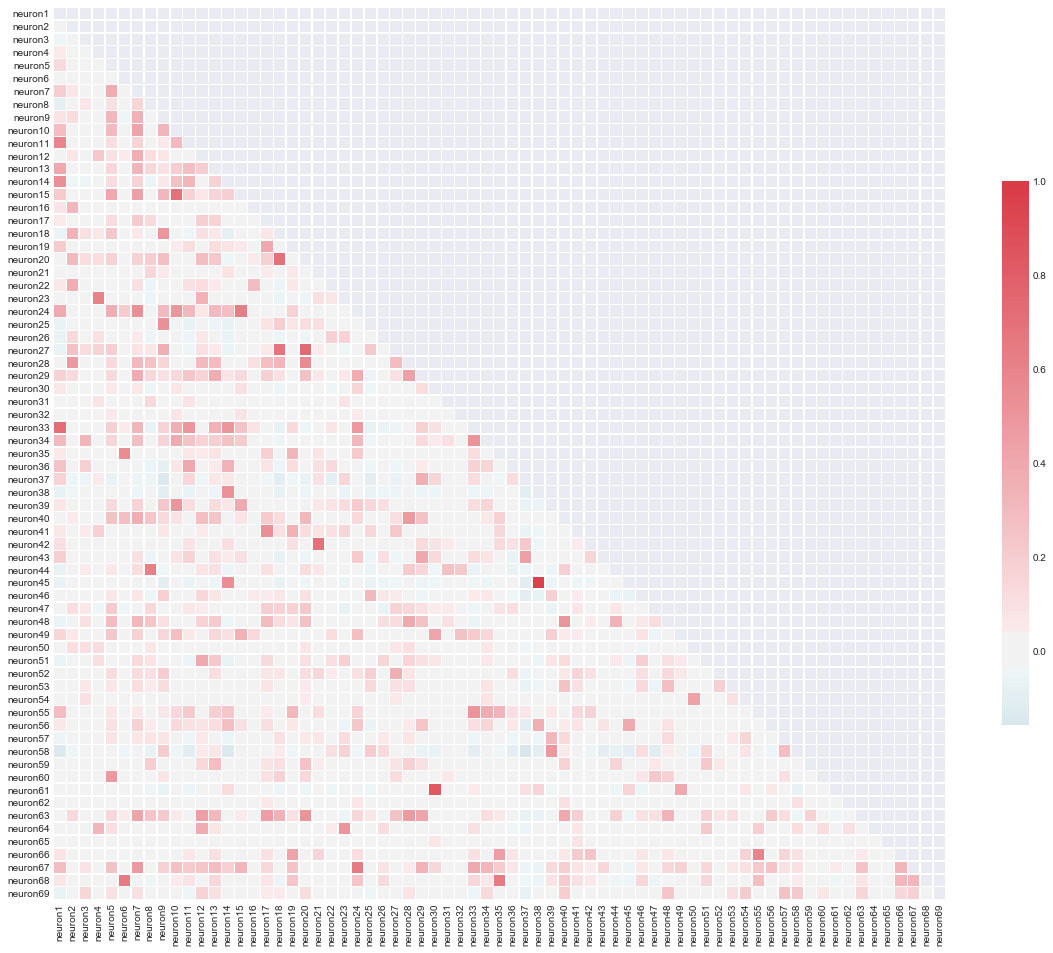

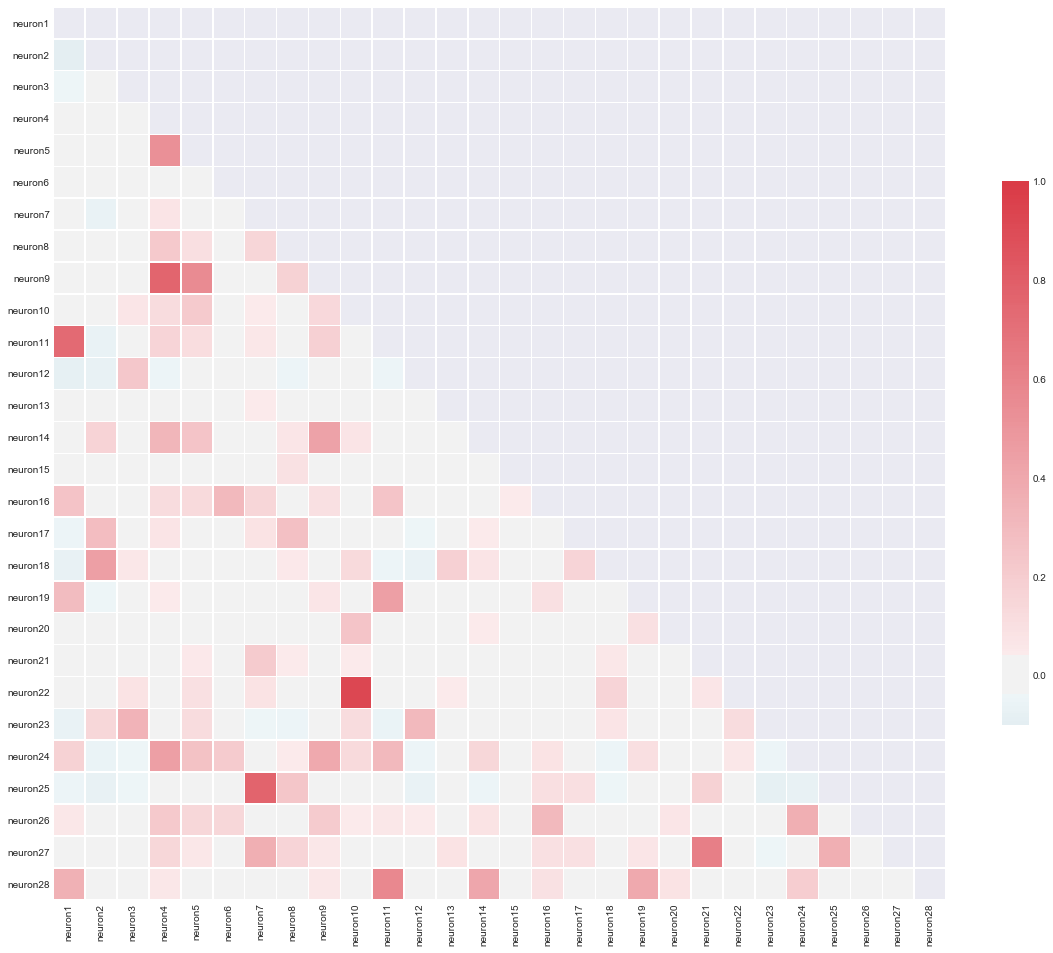

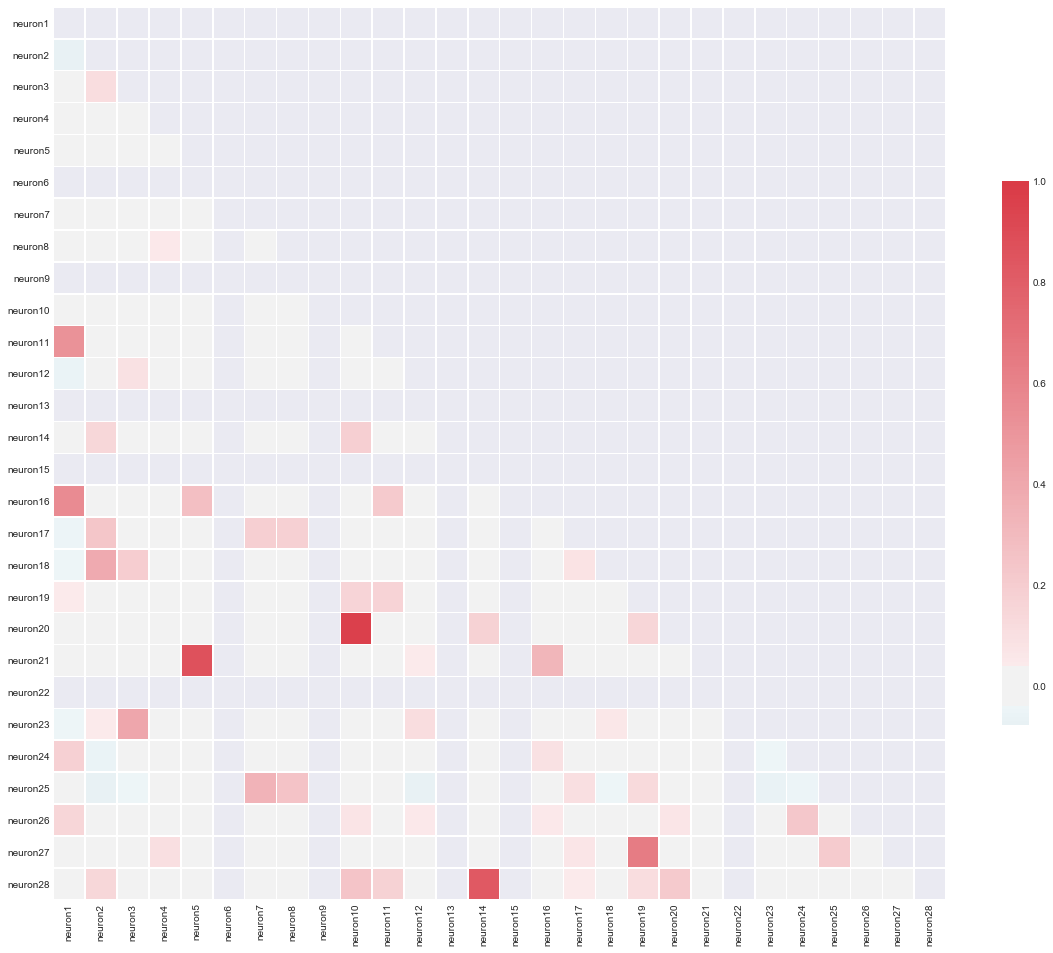

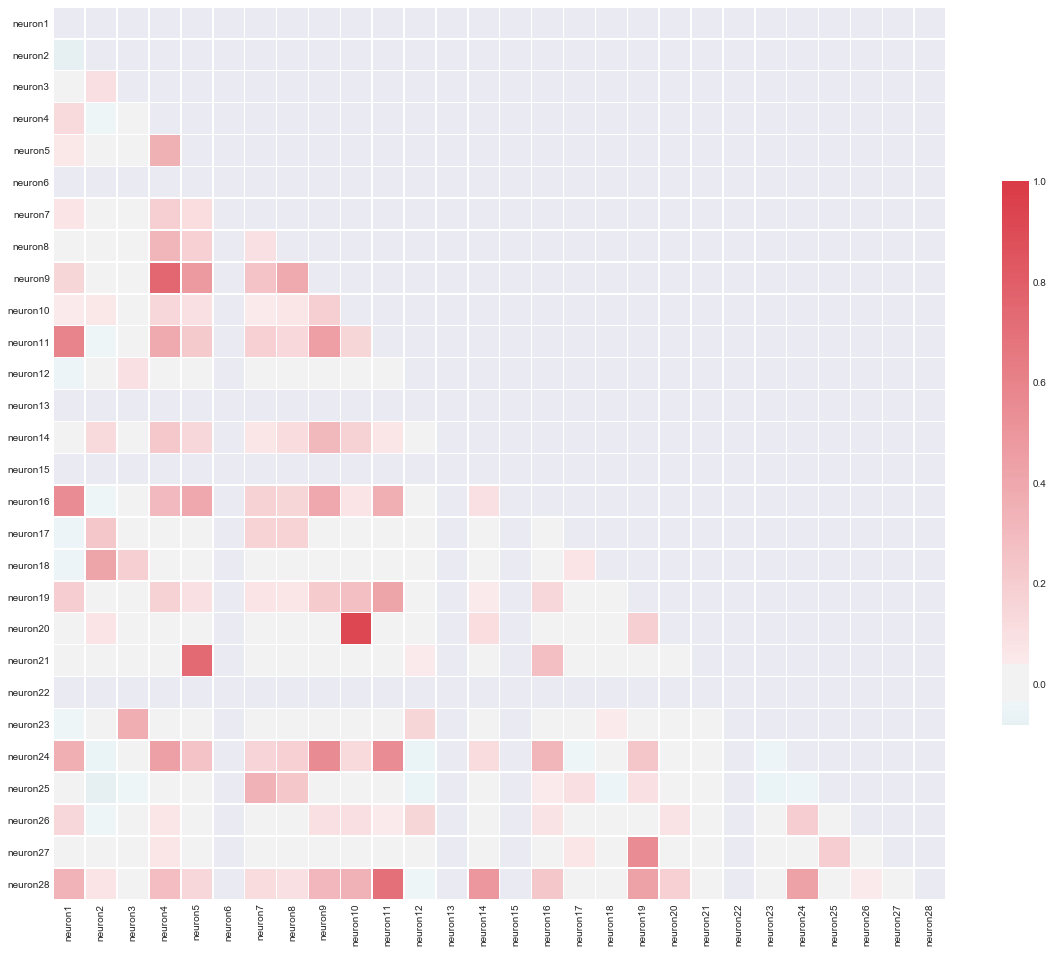

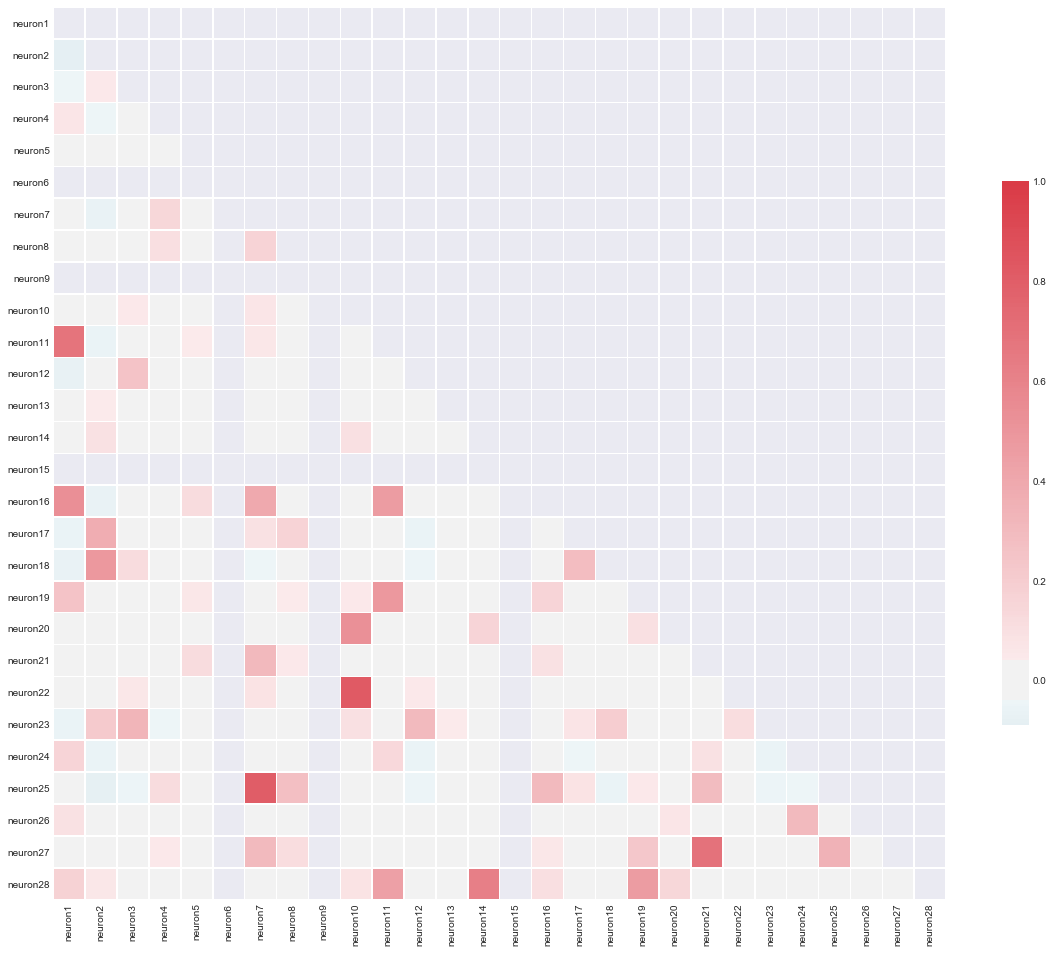

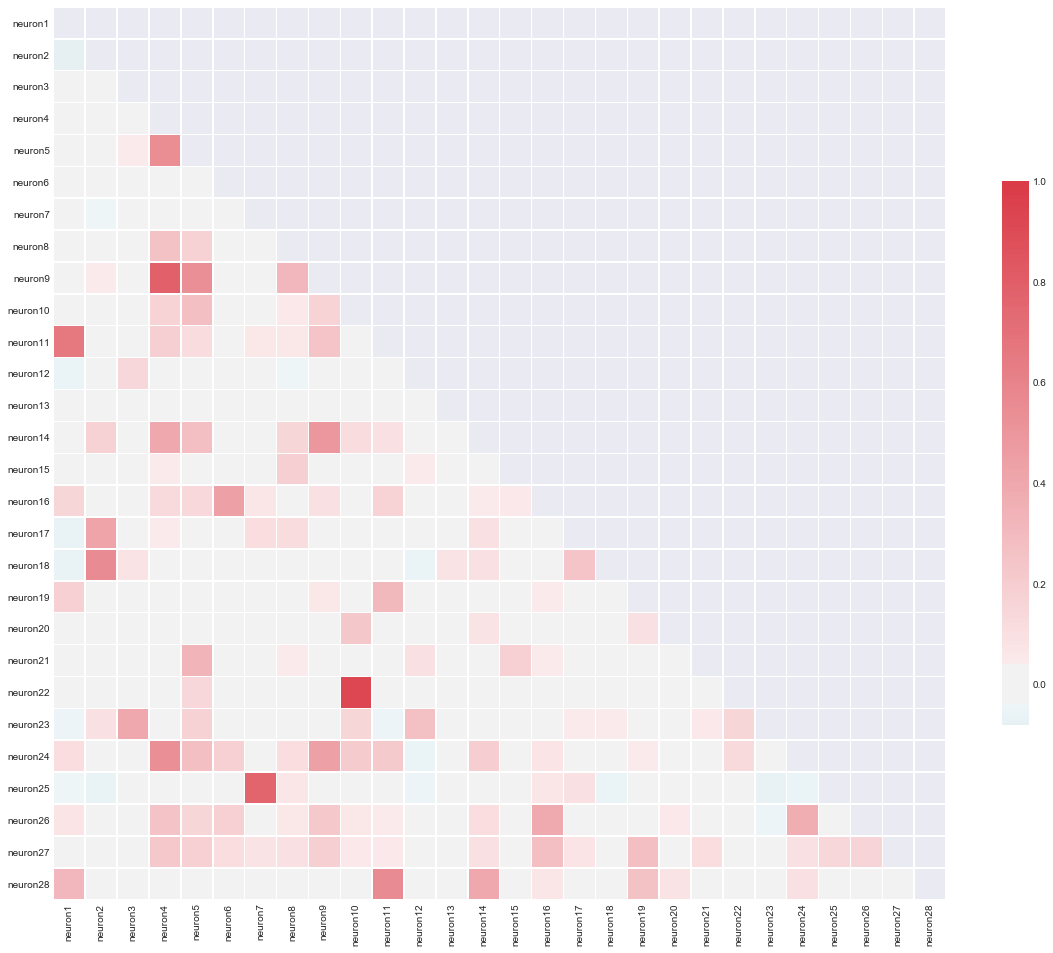

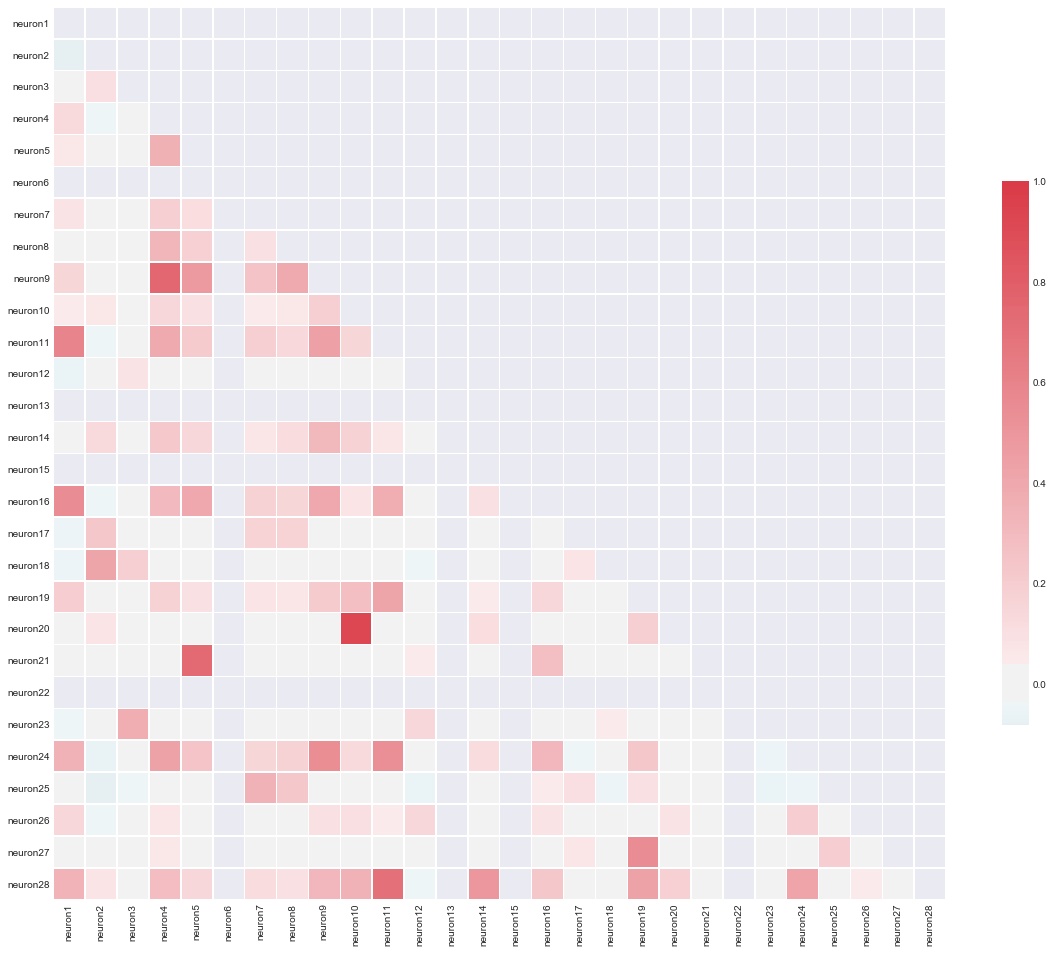

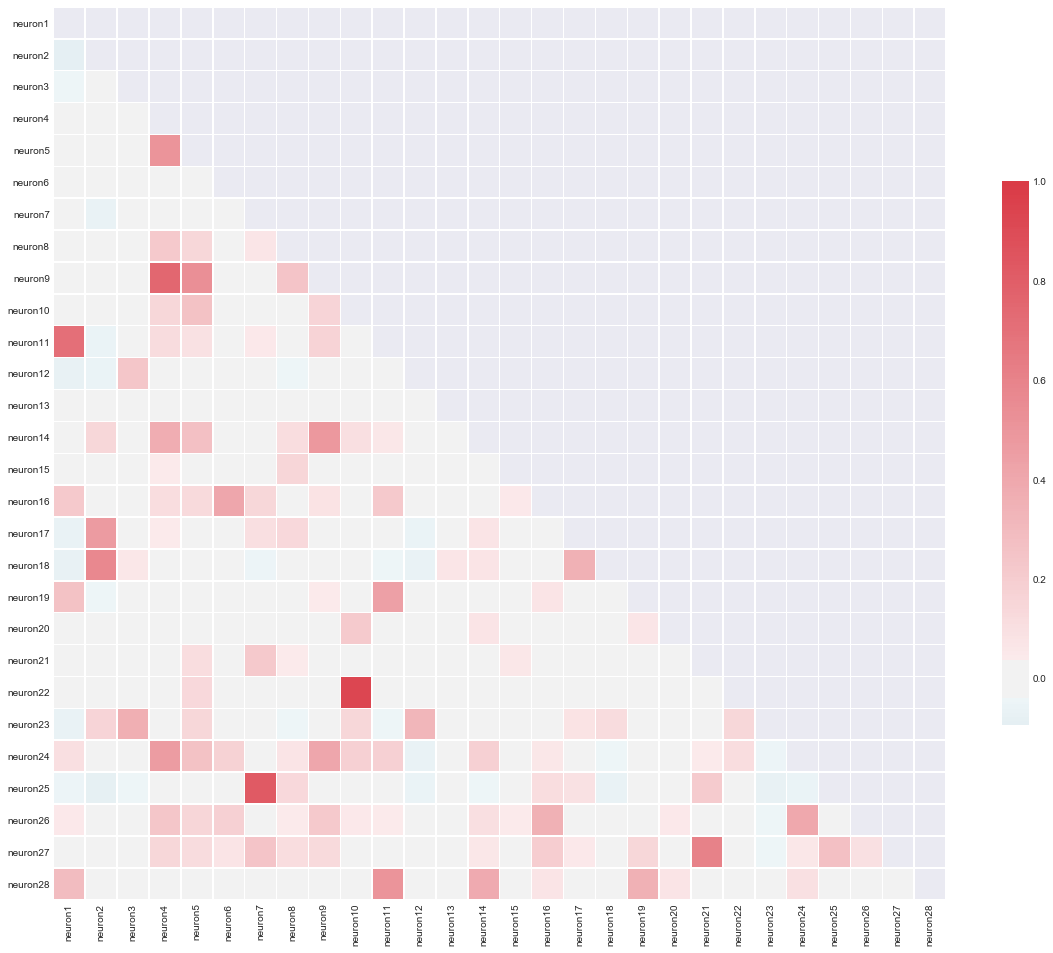

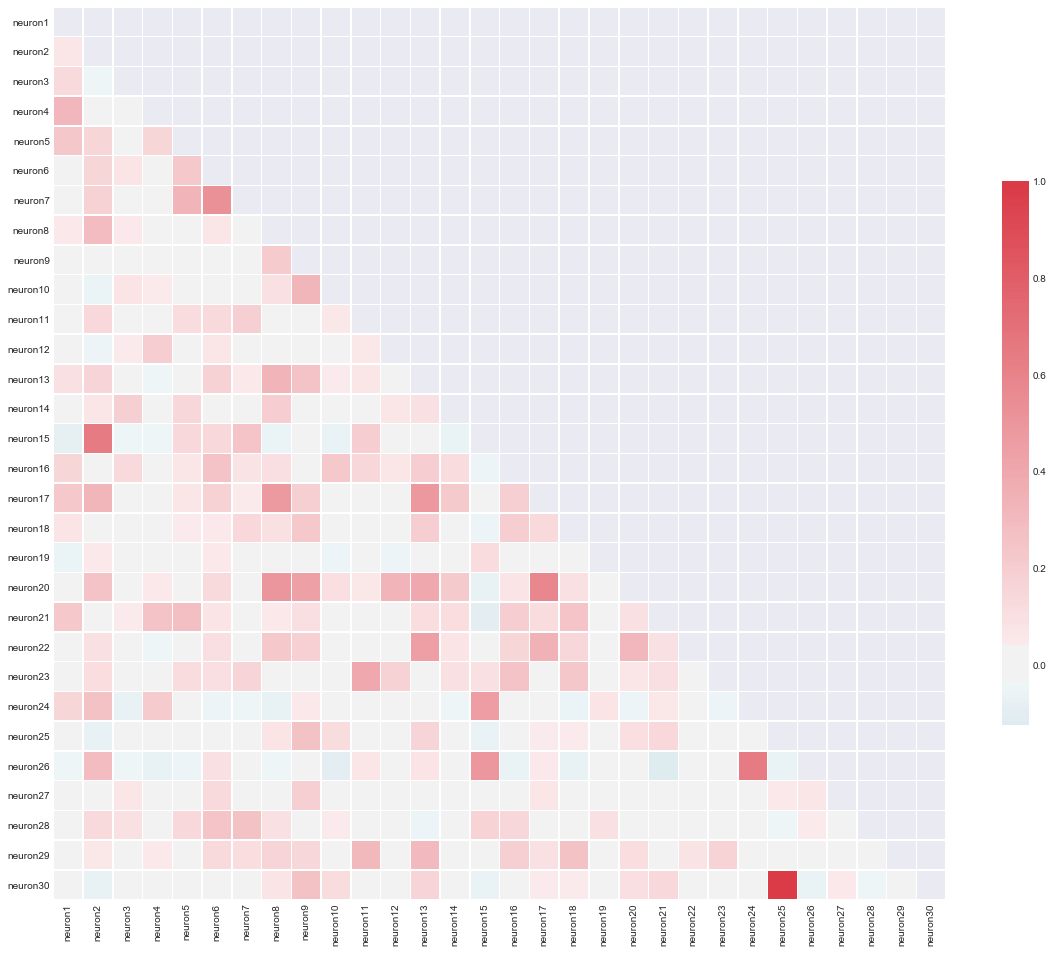

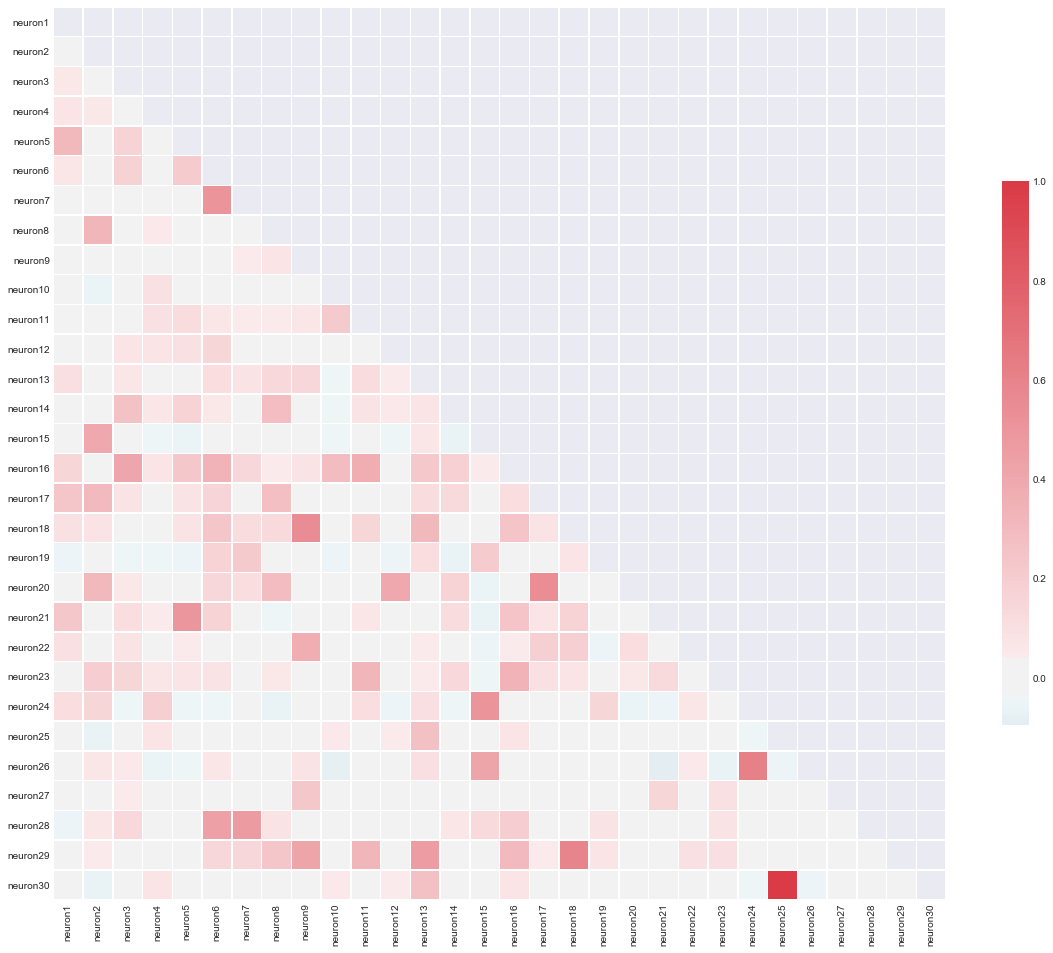

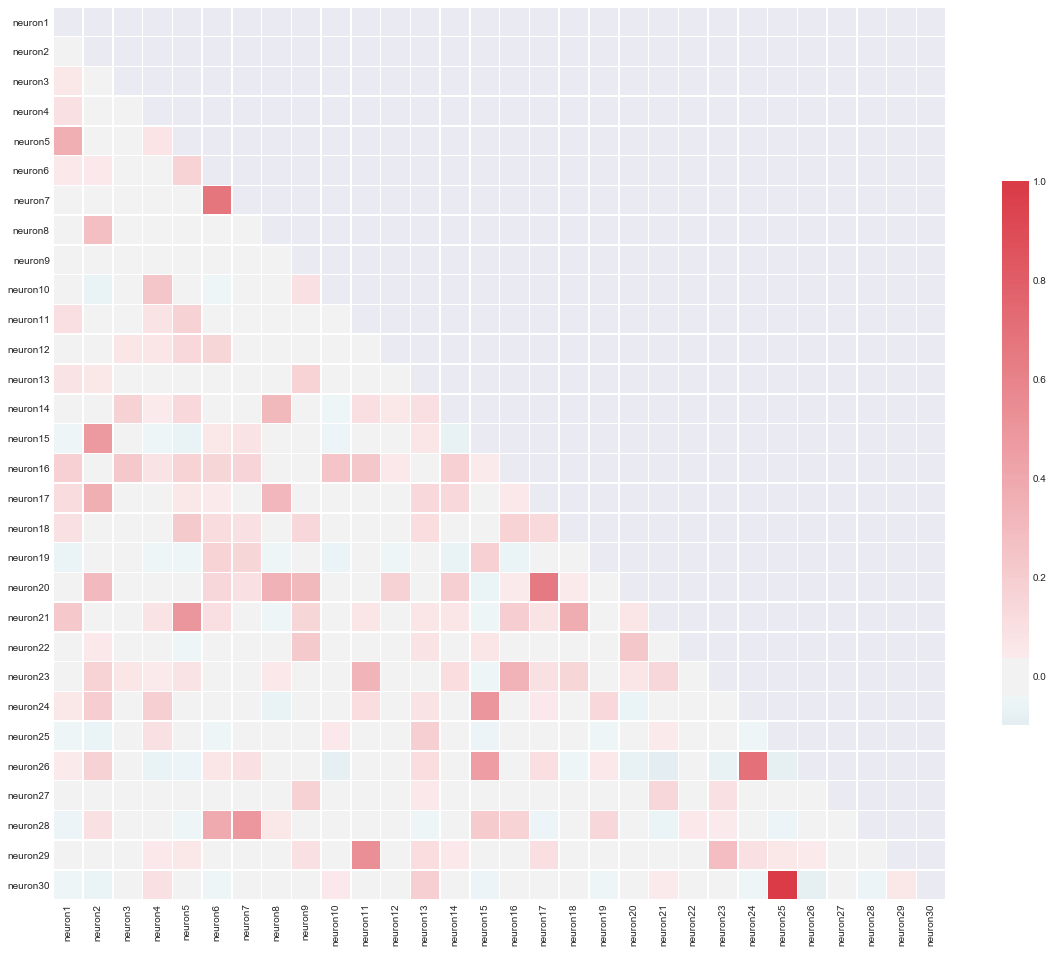

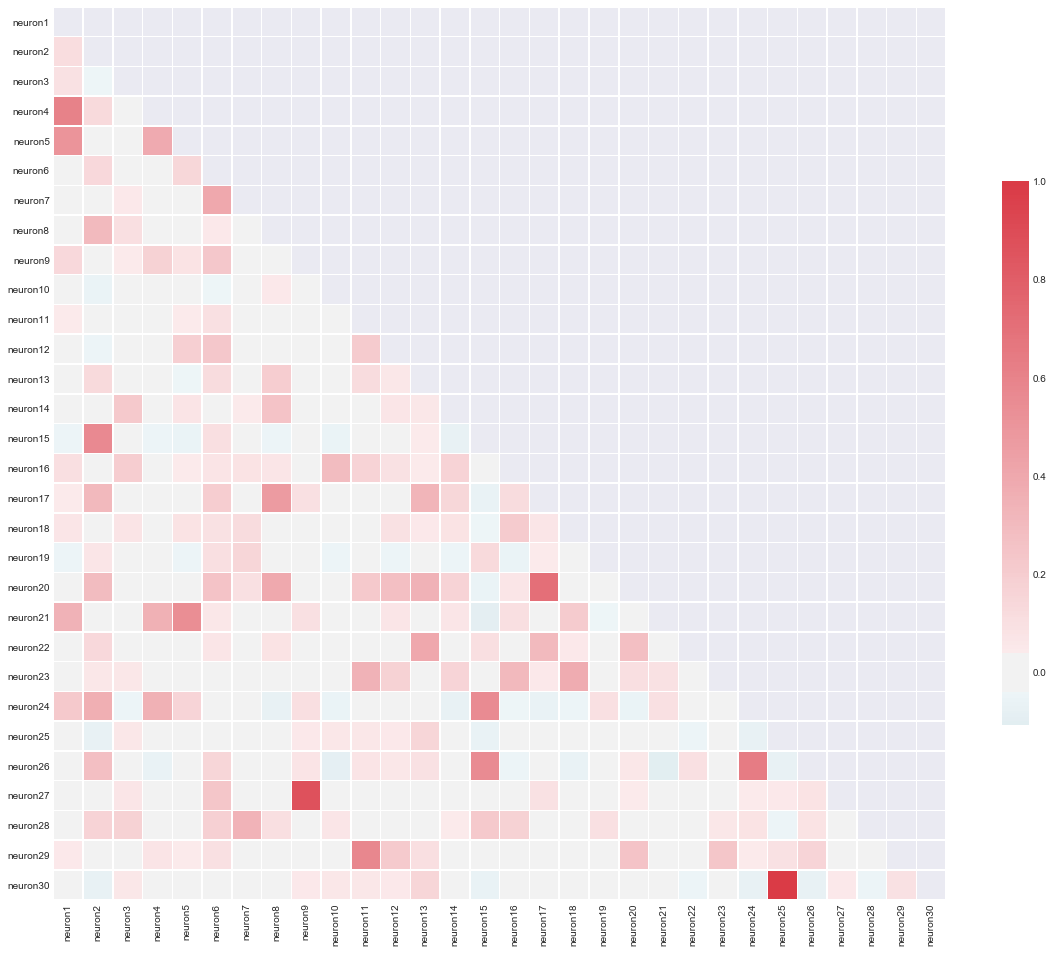

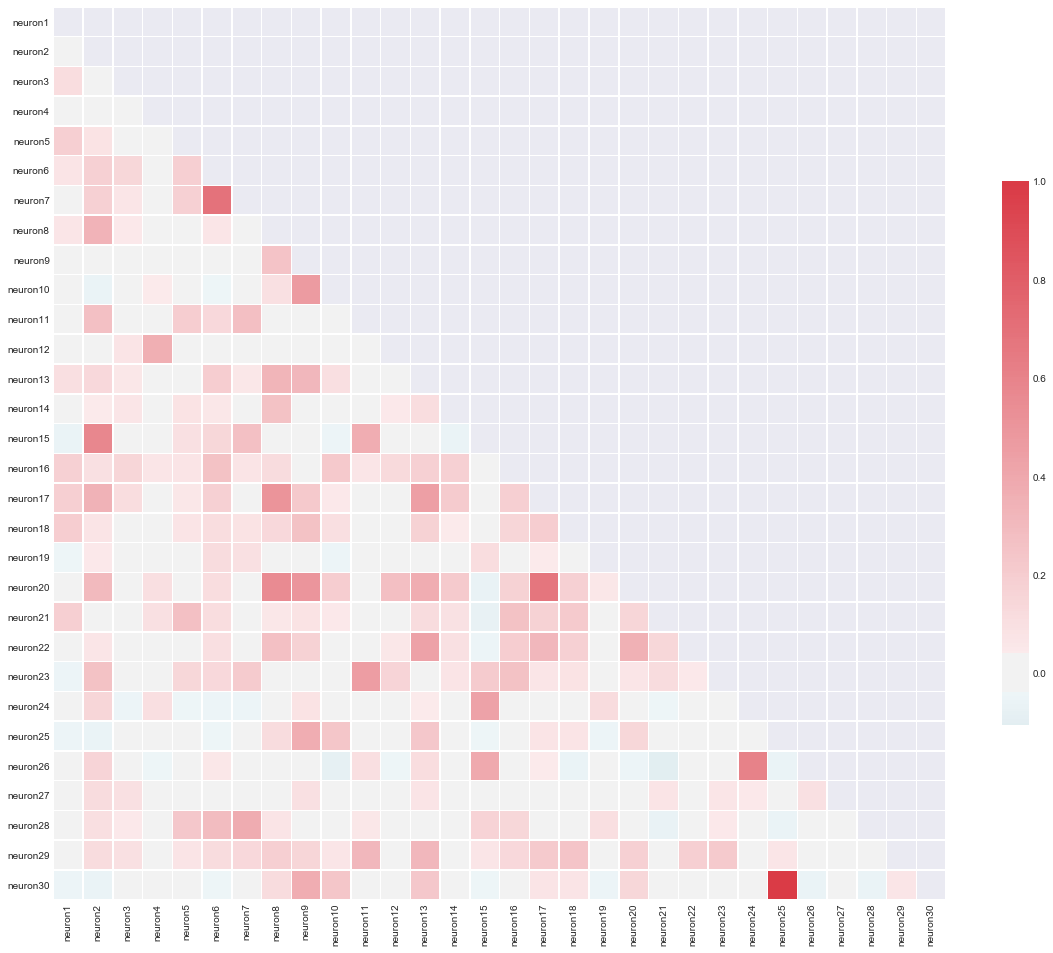

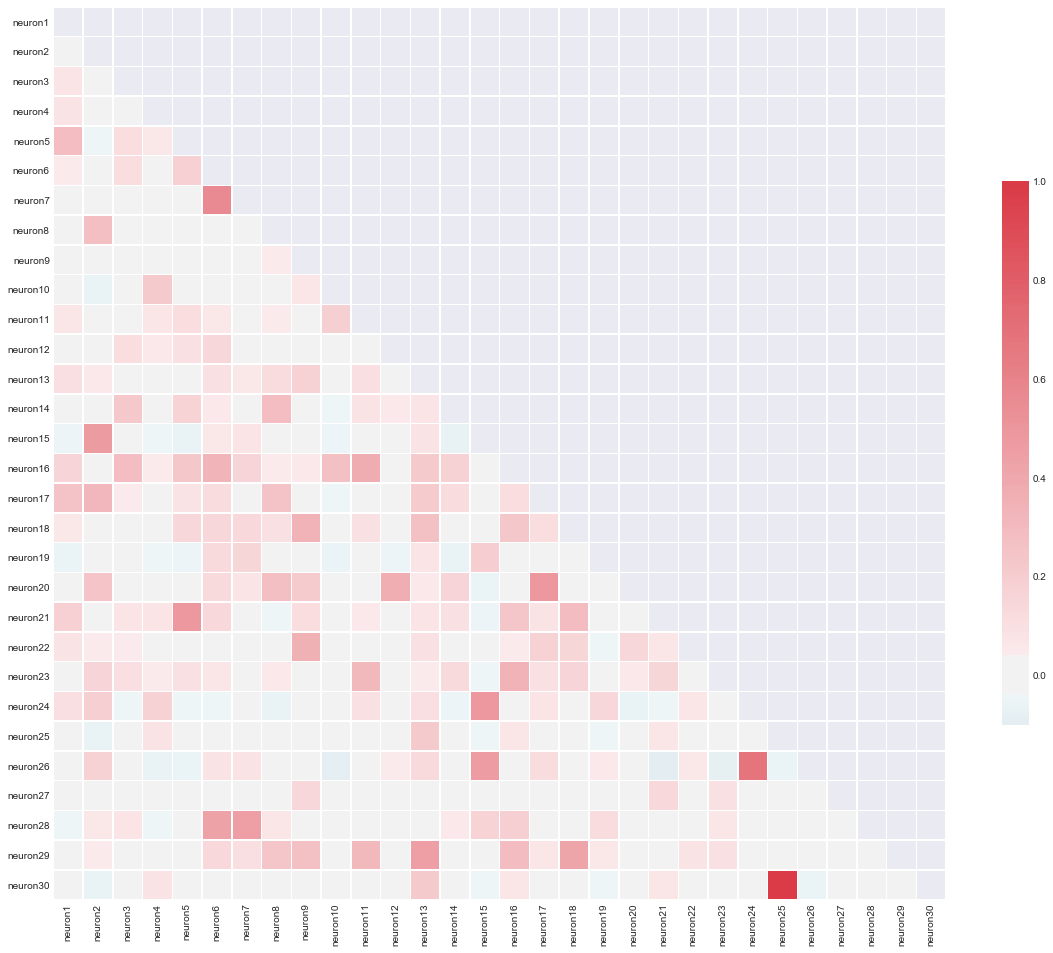

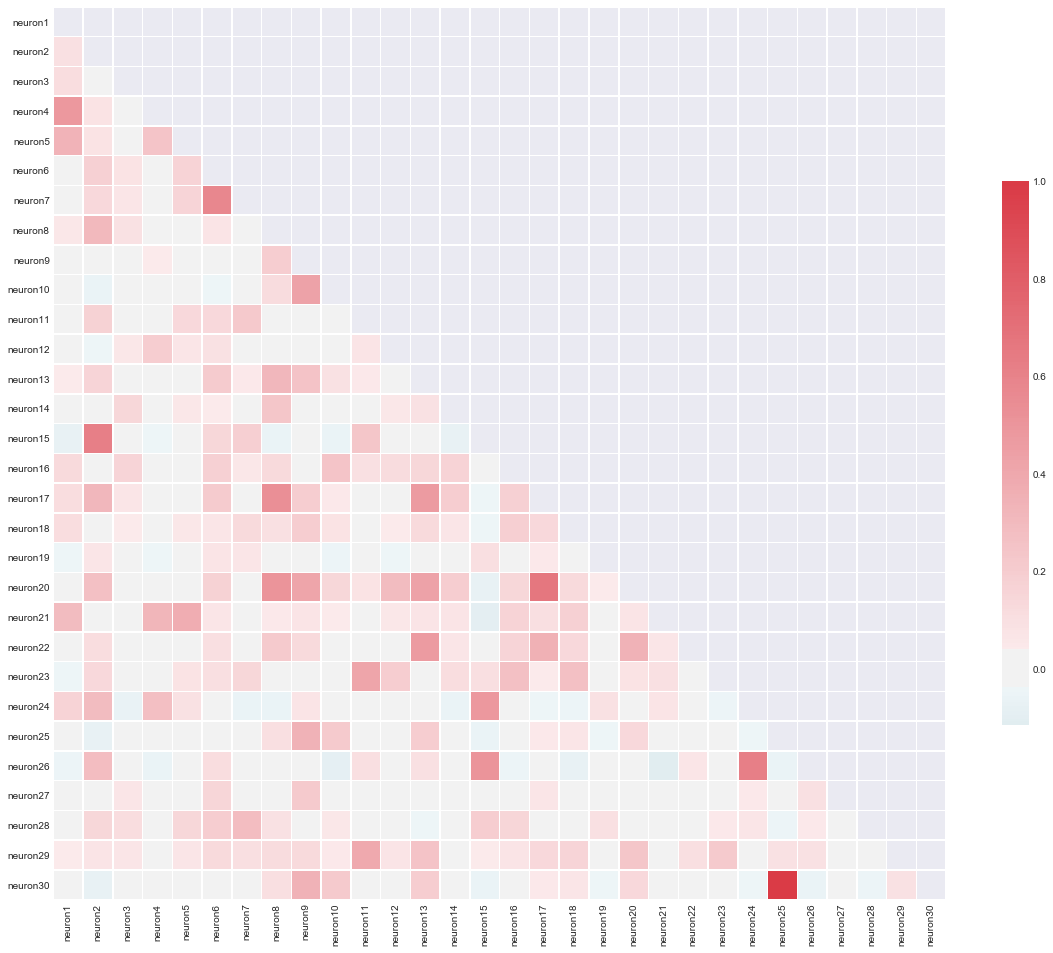

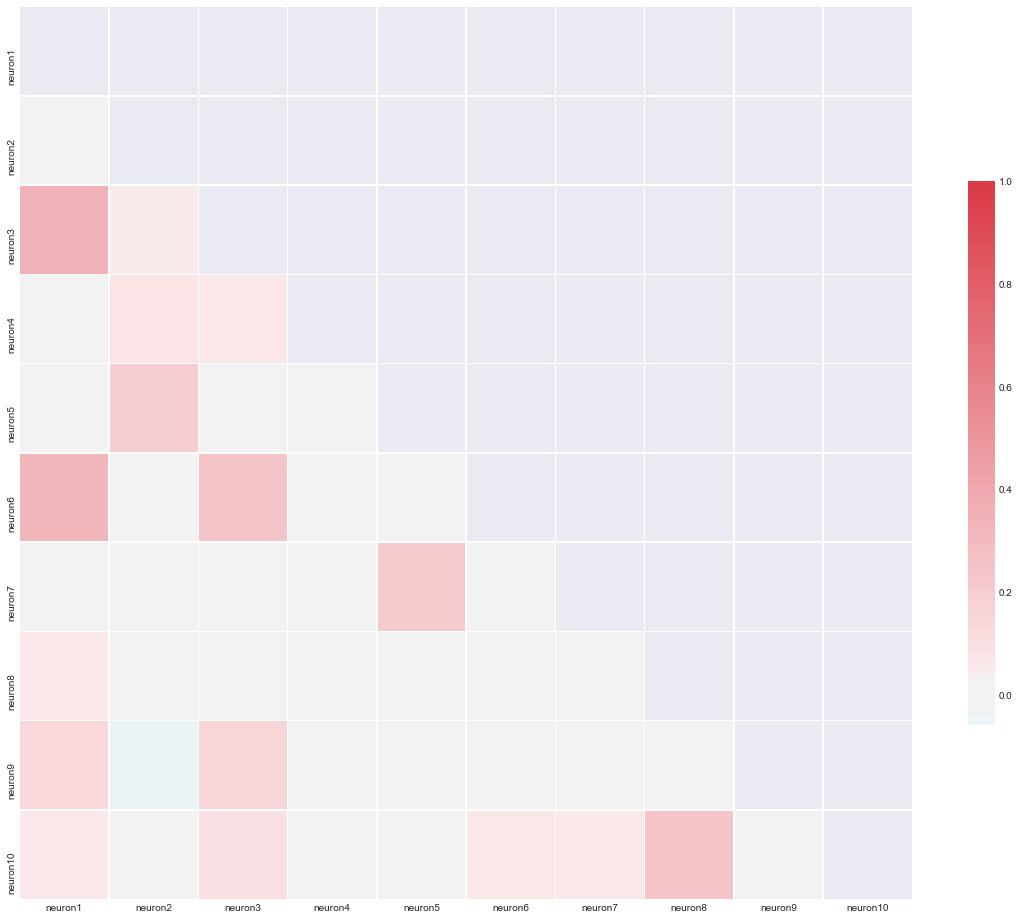

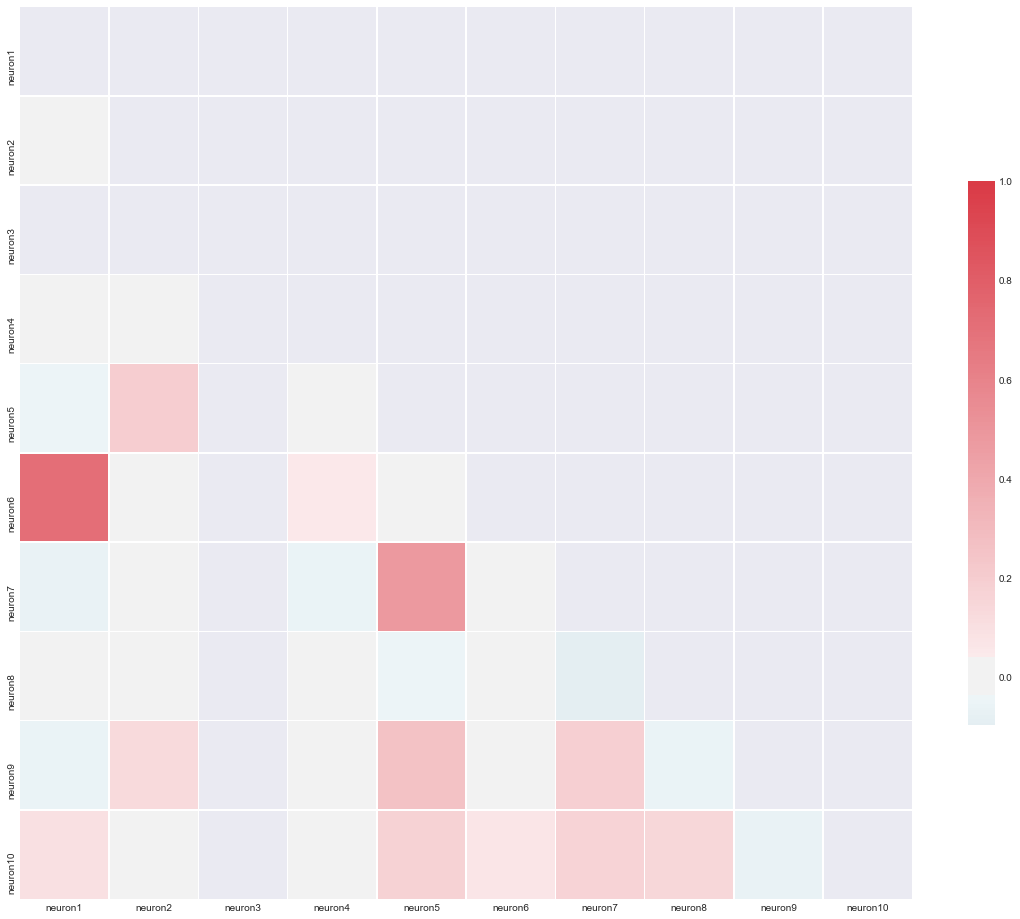

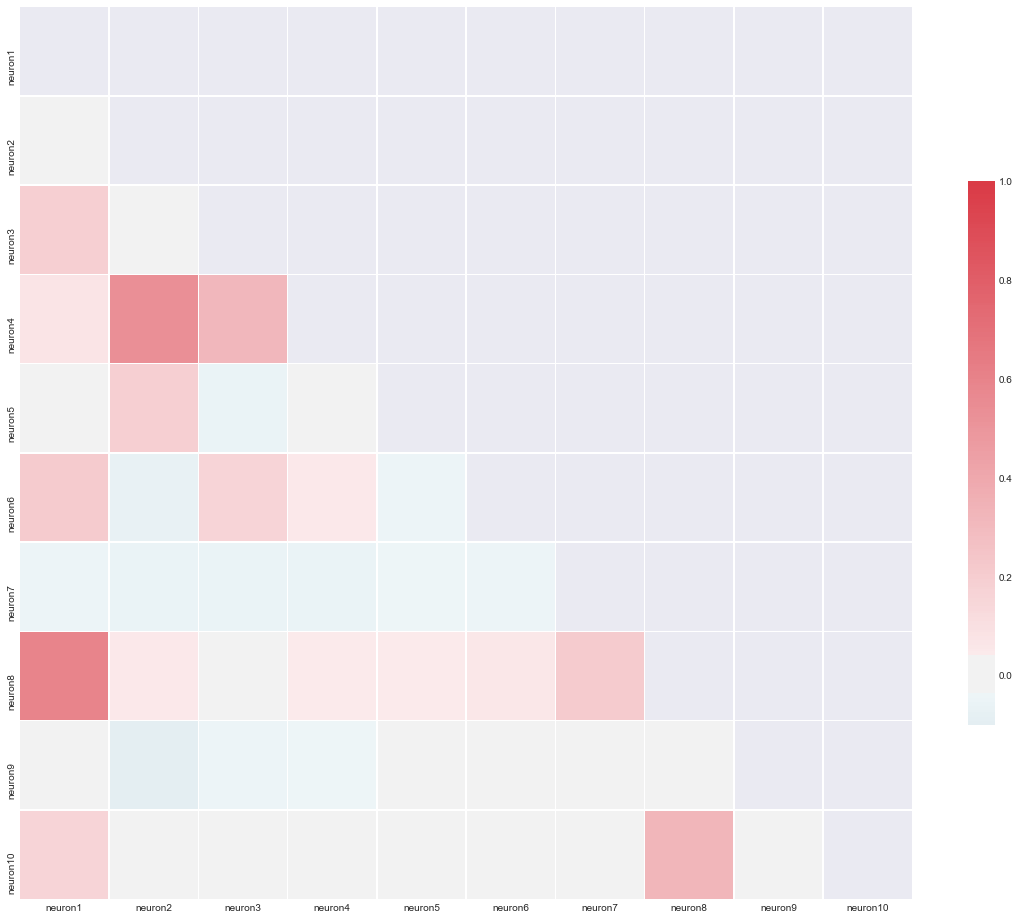

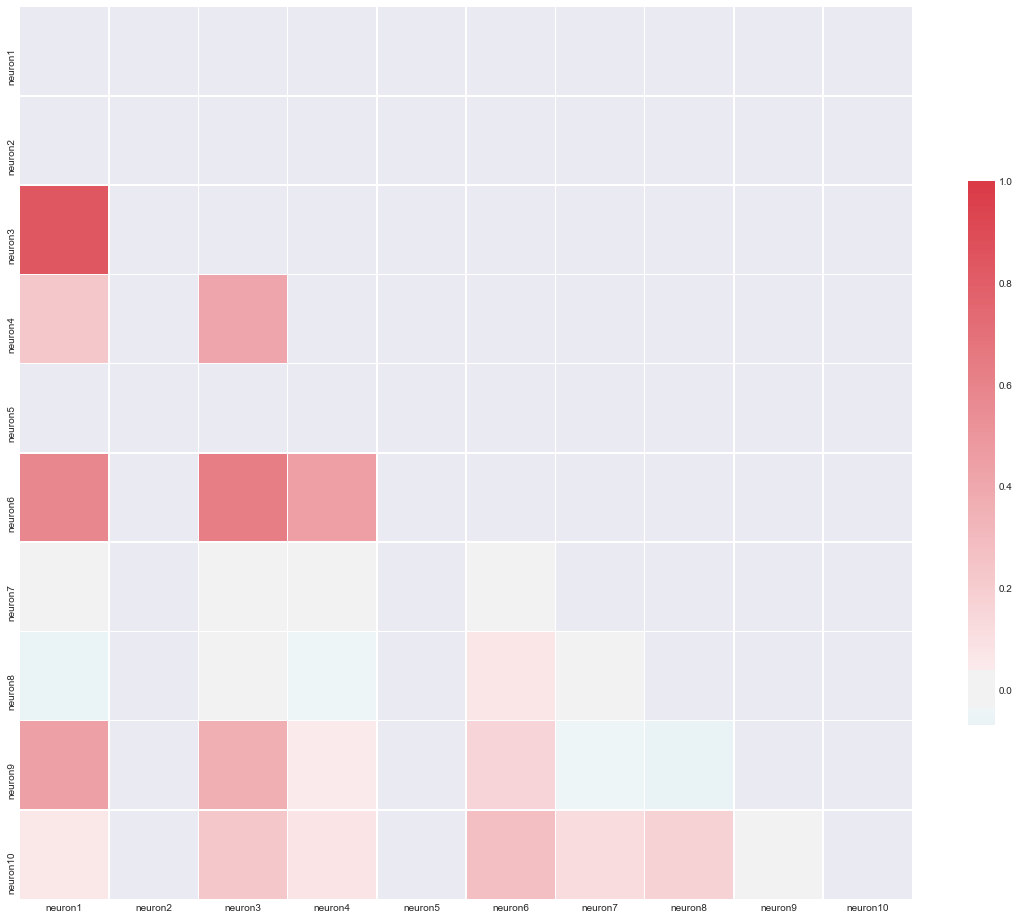

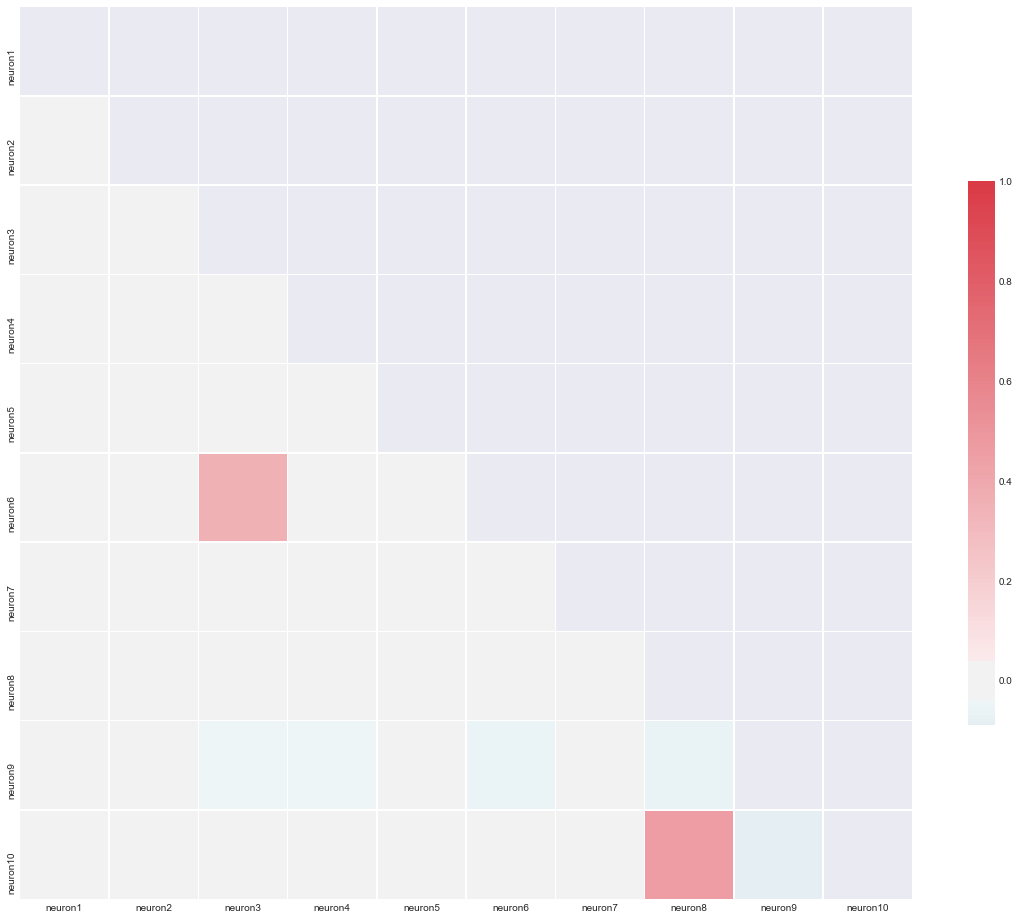

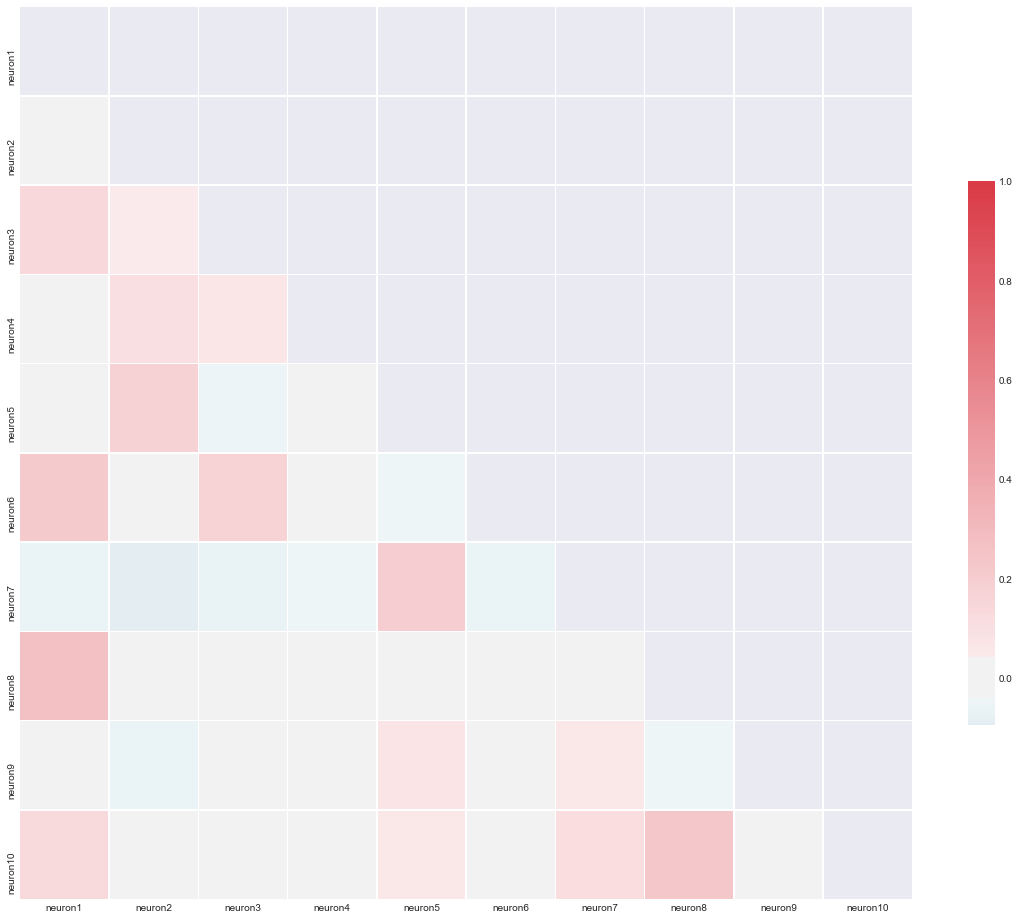

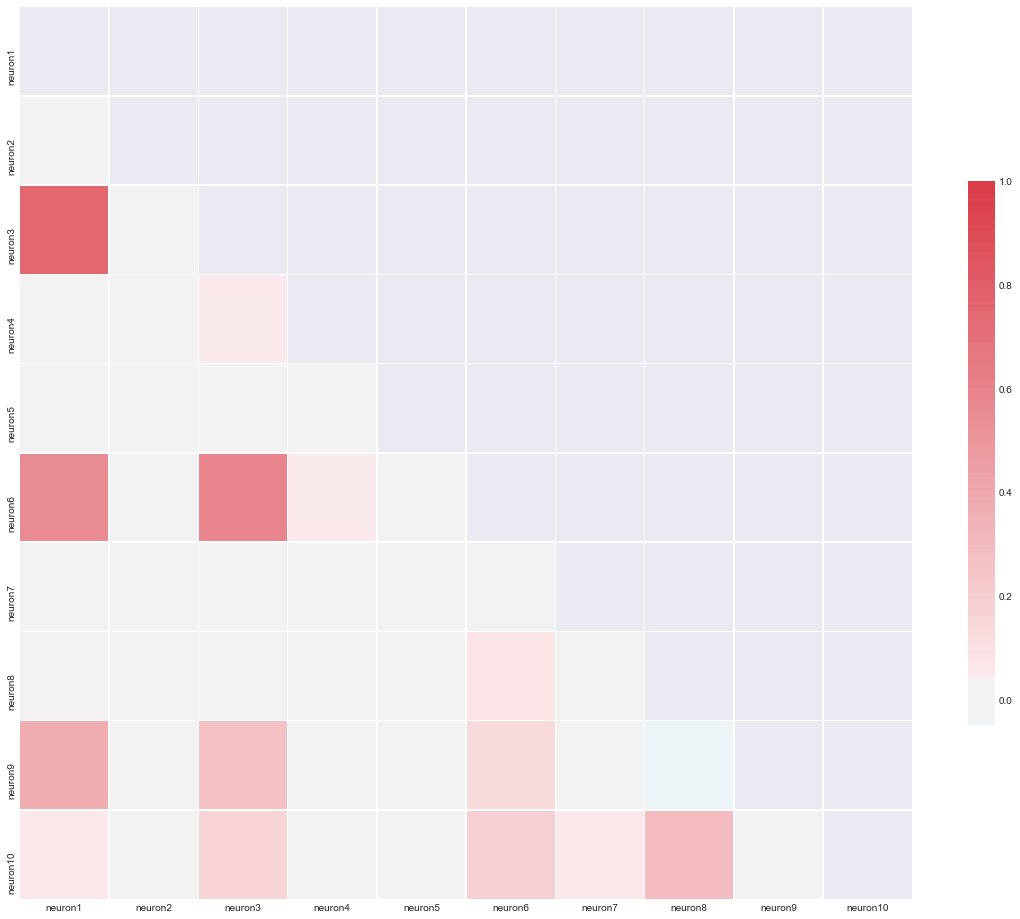

In [8]:
behaviors = ["Arena_centerpoint", "Open1_centerpoint", "Open2_centerpoint", "Closed1_centerpoint", "Closed2_centerpoint", "OpenArms_centerpoint", "ClosedArms_centerpoint"]

for animal in animal_dataframes:
    print(animal)
    for behavior in behaviors:
        print("      ----> {}".format(behavior))
        current_dataframe = animal_dataframes[animal]["neuron_concated_behavior"]
        indices = current_dataframe.loc[current_dataframe[behavior] != 0].index
        au.plot_correlation_heatmap(animal_dataframes[animal]["cell_transients_dataframe"].iloc[indices], size=20)

In [9]:
def activity_by_neurons(concated_df, neuron_names, *behaviors, frame_rate=10):
    """Computes the neuron activity rates for given behaviors
    
    This function computes the rates for a given animal's activity and  
    neuron, given some set of behaviors.

    Args: 
        concated_df: a concatenated pandas DataFrame of the neuron activity and 
        the corresponding behavior, for a given animal.
        neuron_names: the names of the neurons whose rates are to be computed.
        behaviors: a list of the behaviors for which to compute the activity rates. 
        frame_rate: the framerate to multiply the rate by, default is 10.

    Returns: 
        activity_df: a pandas DataFrame of the neuron activity rates.
    """
    activity_df = pd.DataFrame(columns=behaviors)
    for behavior in behaviors:
        if behavior in concated_df.columns:
            activity_df.loc[:, behavior] = frame_rate * concated_df.loc[concated_df[behavior] != 0, neuron_names].mean()
        elif '&' in behavior:
            beh1 = behavior.split('&')[0]
            beh2 = behavior.split('&')[1]
            activity_df.loc[:, behavior] = frame_rate * concated_df.loc[(concated_df[beh1] != 0) & ((concated_df[beh2] != 0)), neuron_names].mean()
        elif '|' in behavior:
            beh1 = behavior.split('|')[0]
            beh2 = behavior.split('|')[1]
            activity_df.loc[:, behavior] = frame_rate * concated_df.loc[(concated_df[beh1] != 0) | ((concated_df[beh2] != 0)), neuron_names].mean()

    return activity_df

## Create a dictionary that will store the neuron activity rates dataframes for each animal

In [10]:
neuron_activity_rates = dict()

for animal in animal_dataframes:
    print(animal)
    if not animal in neuron_activity_rates:
        neuron_activity_rates[animal] = activity_by_neurons(animal_dataframes[animal]["neuron_concated_behavior"], animal_dataframes[animal]["cell_transients_dataframe"].columns, "ClosedArms_centerpoint", "OpenArms_centerpoint", "OpenArms_centerpoint&Running_frames", "ClosedArms_centerpoint&Running_frames", "Running_frames")

drd87
drd73
drd77
drd46


In [11]:
import plotly
import plotly.graph_objs as go

def plot_activity_rates(activity_rates_df, plot_title):
    """Wrapper function for Plotly Bar Charts
        
        This function wraps the Plotly library Bar Chart plotting functionality
        in order to quickly and easily create a bar plot for 
    
    Args:
        activity_rates_df: the pandas DataFrame with all the neuron activity means,
        for corresponding behaviors
    """
    x = [beh.replace('_', "<br>") for beh in activity_rates_df.columns]
    y = [activity_rates_df[behavior].mean() for behavior in activity_rates_df.columns]

    trace1 = go.Bar(
        x=x,
        y=y,
        text=y,
        marker=dict(
            color='rgb(255,100,0)',
            line=dict(
                color='rgb(255,0,25)',
                width=2.5),
            ),
        opacity=0.7
    )

    data = [trace1]
    layout = go.Layout(
        title=plot_title,
    )
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig)

## Plot the neuron activity rates bar plots for each corresponding animal

In [12]:
for animal in neuron_activity_rates:
    plot_title = "Neuron Activity Rates by Behavior for " + animal
    plot_activity_rates(neuron_activity_rates[animal], plot_title)

## Stack the neuron activity rates dataframes of all the animals, on top of each other

In [13]:
rates_of_all_neurons = pd.concat(list(neuron_activity_rates.values()), ignore_index=True)
rates_of_all_neurons

,ClosedArms_centerpoint,OpenArms_centerpoint,OpenArms_centerpoint&Running_frames,ClosedArms_centerpoint&Running_frames,Running_frames
0,4.293802,0.000000,0.000000,5.765008,3.599939
1,0.795557,6.929681,10.559371,1.510336,2.702058
2,0.459468,5.775742,8.220072,0.864223,3.966759
3,0.241056,8.674212,11.882996,0.130873,2.813605
4,0.581082,5.778961,4.223932,1.000889,3.866073
5,1.441145,0.428662,0.373370,2.065933,1.254641
6,1.745690,2.822634,2.456699,3.099987,2.261637
7,1.135713,0.351443,0.432327,1.251979,2.367477
8,4.469756,1.334083,1.506936,7.944848,4.950065
9,0.312516,2.931461,3.410338,0.709005,2.703992


## Plot the neuron activity rates of all the neurons, combined

In [15]:
plot_activity_rates(rates_of_all_neurons, "Neuron Activity Rates for all Animals Combined")